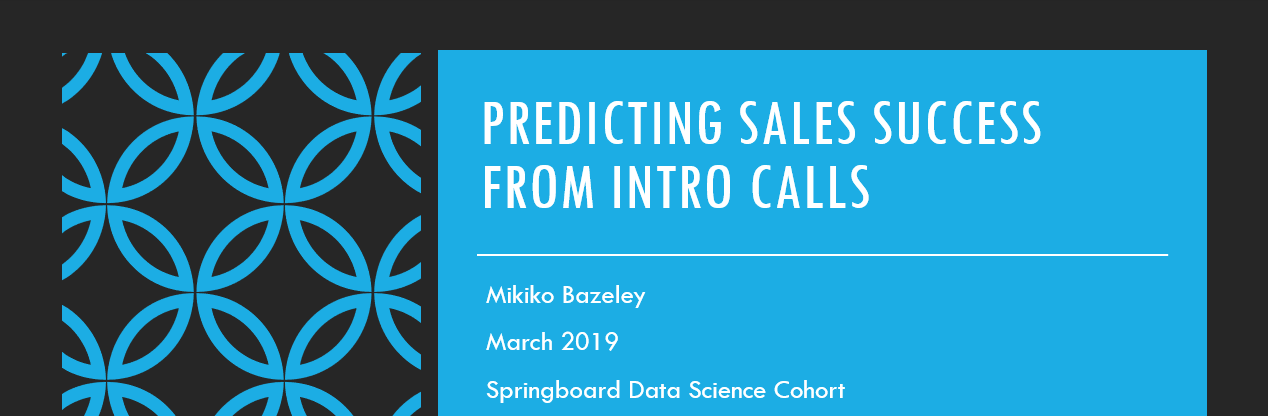

In [1]:
from IPython.display import Image
Image("img/picture.png")

## Introduction:
    
    This project is focused on understanding what are the drivers for demo call qualifications and whether we can create a robust predictive model. Two data sets are utilized (both internal and derived from the company's Redshift data warehouse) focused on leads and "intro calls" (demo calls). The data warehouse collects the data from Salesforce and processes it via ETL but still requires intense data cleansing and wrangling.  
    
    Of the 107 variables in the initial leads dataset and 114 variables in the intro call data set, we'll be focusing on the core variables that relate to the demo calls. Demo calls (or intro calls, term are synonymous) occur after a lead has entered the system and before an opportunity can be created. As a result, predicting the outcome of demo calls (which are hosted by a live person and subjective) can be a tricky judgement call. Being able to classify whether an intro calls will be qualified based on lead characteristics helps create consistency and transparency for both forecasting and training.
    
#### Goals:

    1) Determine if correlations between key sales indicators (account level demographics, lead characteristics, etc) and qualification outcome.
    
    2) Determine if there a statistically significant difference between qualified and disqualified intro calls in regards to key characteristics.
    
    3) Create machine learning model that allows us to predict whether an introcall will be qualified and understand the different drivers of qualification across models.

In [2]:
import psycopg2
from sqlalchemy.engine import url as sa_url
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from scipy.stats import linregress
from scipy import stats

from sklearn.tree import export_graphviz
import pydot

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [3]:
#function to clean dates
def clean_dates(df, oldColName, newColName, timedatepattern):
    """This will take a dataframe, a number of column names & create new columns of datetime objects"""
    emptyDateFrame = []
    colPosition = len(df.columns)
    for date in df[oldColName]:
        if date != None:
                if pd.isna(date):
                        emptyDateFrame.append(np.nan)
                else:        
                        if isinstance(date, str):
                                emptyDateFrame.append(datetime.datetime.strptime(date, timedatepattern))
                        else:
                                emptyDateFrame.append(datetime.datetime.strptime(str(date), timedatepattern))
        else:
            emptyDateFrame.append(None)
    df.insert(colPosition, newColName, emptyDateFrame)
    del df[oldColName]
    return df

In [4]:
#function to rempa values based on provded dicts
def clean_map(df, dictToMap, oldColName):
    """This will take a dataframe, 
    a number of column names & 
    create new columns of datetime objects"""
    newColName = oldColName + "_map"
    df[newColName] = df[oldColName].map(dictToMap) 
    del df[oldColName]
    return df


In [5]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [6]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.abs(np.mean(data_1) - np.mean(data_2))
    newDiff = diff.item()

    return newDiff

In [7]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [8]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return np.array(perm_replicates)

In [9]:
def draw_perm_reps_with_ecdf(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        _=i
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        
         # Compute ECDFs
        x_1, y_1 = ecdf(perm_sample_1)
        x_2, y_2 = ecdf(perm_sample_2)

        # Plot ECDFs of permutation sample
        _ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red', alpha=0.02)
        _ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue', alpha=0.02)


        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return np.array(perm_replicates), _

In [10]:
def bootstrap_replicate_1d(data, func):
    replicatedArray = np.random.choice(data.flatten(), size=len(data))
    return func(replicatedArray)

In [11]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] =  bootstrap_replicate_1d(data,func)  

    return bs_replicates

## Data Gathering & Wrangling

### Data Gathering

We'll first connect to the Redshift database using SQLAlchemy and query the tables. Because fields are constantly shifting (although not the most optimal strategy especially around extremely large data sets), we'll be bringing in all the data we need and then cleaning and dropping as we go along.

In [12]:
#Create the database connection to the company database
db_connect_url = sa_url.URL(
            drivername='postgresql+psycopg2',
            username='username',
            password='password',
            host='host',
            port='port',
            database='database'
)
engine = create_engine(db_connect_url)
con = engine.connect()


#Ensure connection to the right schemas within the tables within the database
session = sessionmaker()
session.configure(bind=engine)
s = session()
SetPath = "SET search_path TO %s" % 'ods'
s.execute(SetPath)

In [13]:
# Query vis SQL Aclhemy th Leads and Introcalls tables to create the lead scoring table

leads_query = "Select * from sf_lead"
rs = s.execute(leads_query)
leads_raw = pd.DataFrame(rs.fetchall())
leads_raw.columns = rs.keys()


pd.DataFrame(leads_raw.head(50)).to_csv('leads_sample.csv')
leads_raw.to_csv('leads_full_data.csv')


In [14]:
#Intro Calls
intro_calls_query = "Select * from sf_intro_call__c"
rs = s.execute(intro_calls_query)
intro_calls_raw = pd.DataFrame(rs.fetchall())
intro_calls_raw.columns = rs.keys()

pd.DataFrame(intro_calls_raw.head(50)).to_csv('intro_calls_sample.csv')
intro_calls_raw.to_csv('intro_calls_full_data.csv')


In [15]:
s.close()
con.close()

### Data Preview

Each intro call should have a 1 to 1 relationship with each lead (contacts are also possible). 

We'll focus mainly on intro calls that are closed (i.e. have been completed) with leads. We should have a much higher volume of leads relative to intro calls (and many of those leads will be duplicated or incomplete) so we'll make the assumption that (given intro calls are scheduled by a live person as opposed to automation) the leads connected to intro calls have the most data available out of any other instant of that lead. 

In [16]:
# Lead Data

print("___________________________________Summary on Leads Object___________________________________")
print("\n")
print("Leads Raw Info:", leads_raw.info())


___________________________________Summary on Leads Object___________________________________


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497058 entries, 0 to 497057
Columns: 107 entries, id to clearbit_employees__c
dtypes: bool(17), datetime64[ns](1), float64(5), int64(1), object(83)
memory usage: 349.4+ MB
Leads Raw Info: None


In [17]:
print("Leads Raw Count:", leads_raw.count())
lead_raw_list = list(leads_raw.columns)

Leads Raw Count: id                                    497058
isdeleted                             497058
masterrecordid                            40
lastname                              497058
firstname                             385937
salutation                              6333
name                                  497058
title                                 305747
company                               497058
street                                 68464
city                                  429610
state                                 251466
postalcode                             62166
country                               447886
email                                 494250
leadsource                            496662
status                                497058
industry                               41291
ownerid                               497058
hasoptedoutofemail                    497058
isconverted                           497058
converteddate                         

In [18]:
#Intro Call Data

print("___________________________________Summary on Intro Calls Object___________________________________")
print("\n")
print("Intro Call Raw Info:",intro_calls_raw.info())


___________________________________Summary on Intro Calls Object___________________________________


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23429 entries, 0 to 23428
Columns: 114 entries, id to product_s__c
dtypes: bool(16), datetime64[ns](2), float64(5), object(91)
memory usage: 17.9+ MB
Intro Call Raw Info: None


In [19]:
print("Intro Call Raw Count:",intro_calls_raw.count())
intro_calls_raw_list = list(intro_calls_raw.columns)

Intro Call Raw Count: id                                         23429
ownerid                                    23429
isdeleted                                  23429
name                                       23429
currencyisocode                            23429
recordtypeid                               18389
createddate                                23429
createdbyid                                23429
lastmodifieddate                           23429
lastmodifiedbyid                           23429
systemmodstamp                             23429
lastactivitydate                            1312
lastvieweddate                                 0
lastreferenceddate                             0
actual_start_date_time__c                      0
application_type__c                        17796
assigned_to__c                             23417
lead_additional_phone__c                    6329
lead_company__c                            22841
lead_email__c                              2276

### Data Cleaning 

Once we've verified we have all the fields & data we need we'll start subsetting out data, cleaning, and dropping unecessary tables. Leads will be left joined to intro calls through a common ID. 

In [20]:
# Fields to Use for master data set
lead_fields_masterDataSet =['email','firstname','lastname','title','customer_type__c','company','street','city','state','country','linkedin_page__c','traffic_channels__c','marketing_channel_campaign_name__c','landing_page__c','landing_page_url__c','google_campaign__c','leadsource','converteddate','status_reason__c','status','id','convertedaccountid','convertedcontactid','convertedopportunityid','ownerid','createdbyid','createddate','duplicate_lead__c','isconverted','isdeleted','pitch__c','infer3__infer_score__c','total_calls__c','total_emails__c','users_amount__c','marketing_camp_id__c','marketing_channel_ad_id__c','of_employees_category__c']
intro_call_fields_masterDataSet = ['id','lead_name__c','related_account__c','related_opportunity__c','ownerid','contact__c','assigned_to__c','assigned_to_role__c','name','createdbyid','createddate','isdeleted','meeting_status__c','lead_status__c','qualification_date__c','qualified_without_opp_reason_other__c','qualified_without_opportunity_reason__c','rejected_other_reason__c','rejected_reason__c','rescheduled__c','rescheduled_from_intro_call__c','no_show_other_reason__c','no_show_reason__c','additional_user_information__c','meeting_comments__c','sales_comments__c','use_cases_pains__c','customer_employee_facing__c','decision_maker_picklist__c','double_dipper__c','project_due_quarter_fiscal__c','product__c','product_s__c','application_type__c','new_existing_customer__c','intro_call_source_marketing_outbound__c','recordtypeid','created_day_of_the_week__c']


# Isolate out the desired data to combine
leads_join_masterDataSet = leads_raw[lead_fields_masterDataSet]
intro_call_join_masterDataSet = intro_calls_raw[intro_call_fields_masterDataSet]


# Rename Columns
leads_join_masterDataSet.columns = ['email___Lead_PersonalInformation','firstname___Lead_PersonalInformation','lastname___Lead_PersonalInformation','title___Lead_PersonalInformation','customerType___Lead_LeadCompanyInformation','company___Lead_LeadCompanyInformation','street___Lead_LeadCompanyInformation','city___Lead_LeadCompanyInformation','state___Lead_LeadCompanyInformation','country___Lead_LeadCompanyInformation','linkedinPage___Lead_MarketingInformation','trafficChannel___Lead_MarketingInformation','mktChannelcampaign___Lead_MarketingInformation','landingPage___Lead_MarketingInformation','landingPageUrl___Lead_MarketingInformation','googleCampaign___Lead_MarketingInformation','leadsource___Lead_MarketingInformation','converteddate___Lead_ConversionInformation','statusReason___Lead_ConversionInformation','status___Lead_ConversionInformation','PK_LeadID___Lead_ImportantJoinKey','FK_LeadtoAccount___Lead_ImportantJoinKey','FK_LeadtoContact___Lead_ImportantJoinKey','FK_LeadtoOpportunity___Lead_ImportantJoinKey','FK_LeadtoUser___Lead_ImportantJoinKey','createdbyid___Lead_ImportantSystemInfo','createddate___Lead_ImportantSystemInfo','duplicateLead___Lead_ImportantSystemInfo','isconverted___Lead_ImportantSystemInfo','isdeleted___Lead_ImportantSystemInfo','pitch___Lead_AddedInfo','inferScore___Lead_AddedInfo','totalCalls___Lead_AddedInfo','totalEMails___Lead_AddedInfo','usersAmount___Lead_AddedInfo','marketingCampaignID___Lead_AddedInfo','marketingChannelAdID___Lead_AddedInfo','employeeCategory___Lead_AddedInfo']
intro_call_join_masterDataSet.columns = ['PK_IntroCall_ID___IntroCall_ImportantIDInfo','FK_IntroCalltoLead___IntroCall_ImportantJoinKey','FK_IntroCalltoAccount___IntroCall_ImportantJoinKey','FK_IntroCalltoOppty___IntroCall_ImportantJoinKey','FK_IntroCalltoUser___IntroCall_ImportantJoinKey','FK_IntroCalltoUser___IntroCall_ImportantJoinKey','FK_IntroCalltoContacts___IntroCall_ImportantJoinKey','assignedToRole___IntroCall_OtherInfo','name___IntroCall_OtherInfo','createdbyid___IntroCall_ImportantSystemInfo','createddate___IntroCall_ImportantSystemInfo','isdeleted___IntroCall_ImportantSystemInfo','Target___IntroCall_Outcome','leadStatus___IntroCall_Outcome','qualDate___IntroCall_Outcome','qualWithoutOppReason1___IntroCall_Outcome','qualWithoutOppReason2___IntroCall_Outcome','rejectedOtherReason___IntroCall_Outcome','rejectedReason___IntroCall_Outcome','rescheduled___IntroCall_Outcome','rescheduledFromIntroCall___IntroCall_Outcome','noShowReason2___IntroCall_Outcome','noShowReason1___IntroCall_Outcome','addUserInfo___IntroCall_MeetingDetails','meetingComments___IntroCall_MeetingDetails','salesComments___IntroCall_MeetingDetails','useCases___IntroCall_MeetingDetails','customerOrEmployee___IntroCall_MeetingDetails','decisionMaker___IntroCall_MeetingDetails','doubleDipper___IntroCall_MeetingDetails','projectDueQ___IntroCall_MeetingDetails','produce1___IntroCall_MeetingDetails','product2___IntroCall_MeetingDetails','appType___IntroCall_MeetingDetails','newOrExistingCustomer___IntroCall_LeadInformation','introCallMktSource___IntroCall_LeadInformation','recordtypeid___IntroCall_LeadInformation','createdDayOFWeek___IntroCall_AddedInfo']


# Left Join Lead to Intro Call via Intro Call's lead_name_c and Lead's convertedopportunityid
masterDataSet = pd.merge(intro_call_join_masterDataSet,leads_join_masterDataSet, how='left', left_on=['FK_IntroCalltoLead___IntroCall_ImportantJoinKey'],right_on=['PK_LeadID___Lead_ImportantJoinKey'])

#Making a copy - original safe keeping
masterDataSetCopy = masterDataSet.copy()


In [21]:
#DateTime Cleaning & creating new fields
masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy, 'converteddate___Lead_ConversionInformation', 'converteddate___Lead_ConversionInformation_clean','%Y-%m-%d')

#Because of the odd formatting that occasionally comes out of Salesforce we need to take the first 10 characters before the 'tz' denotation
masterDataSetCopy_dateTimeTest['createddate___Lead_ImportantSystemInfo'] = masterDataSetCopy_dateTimeTest['createddate___Lead_ImportantSystemInfo'].str[:10]
masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo'] = masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo'].str[:10]

masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy_dateTimeTest, 'createddate___Lead_ImportantSystemInfo', 'createddate___Lead_ImportantSystemInfo_clean','%Y-%m-%d')
masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy_dateTimeTest, 'createddate___IntroCall_ImportantSystemInfo', 'createddate___IntroCall_ImportantSystemInfo_clean','%Y-%m-%d')

# Creating new fields
masterDataSetCopy_dateTimeTest['introCallCreated_leadCreated_delta'] = (masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo_clean'] - masterDataSetCopy_dateTimeTest['createddate___Lead_ImportantSystemInfo_clean']).dt.days


Using a function I wrote "clean_map", we'll clean up the categorical fields and relabel using dictionaries. The clean_map fucntion takes a dataframe, column name, and dictionary and wil map the value from the dictionary my matchign the key to the column values. It will then return a new dataframe and column (and drop the old column). 

In [22]:
# Re-label & Group Categorical/Picklist fields


rescheduled___IntroCall_Outcome_dict={"Yes":1,"No":0,"":0}
customerOrEmployee___IntroCall_MeetingDetails_dict={"Both":3,"Employee":2,"Customer":1,"Unknown":0,"":0}
createdDayOFWeek___IntroCall_AddedInfo_dict={"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday ":4,"Friday ":5,"Saturday":6,"Sunday":7}
pitch___Lead_AddedInfo_dict={"employeeproductivity":1,"Adoption-Promotion":2,"employeetraining":3,"Employee-Productivity":1,"Employee-Training":3,"Employee-Producitvity":2,"Customer-Care":4,"training":5,"Employee-Training3":3,"Sharepoint":6,"Employee-Productivty":3,"Employee-Producivity":3,"productivity":3,"e0":3,"adoption":2,"Employee-Productivity6":3,"customeronboarding":7,"unomy":8,"top20":9,"Insight Venture Partners":10,"Insight Venture Partner":10,"Salesforce":11,"Employee-Traininge":3,"Workday":12,"e3":3,"[pitch]":13,"Employee-Integration":14,"":0}
decisionMaker___IntroCall_MeetingDetails_dict={"Yes":3,"Influencer":2,"No":1,"":0}
employeeCategory___Lead_AddedInfo_dict={"Strategic":4,"MM":3,"Enterprise":2,"Startup":1,"":0}
Target___IntroCall_Outcome_dict={"Attributed":1,"Cancelled":0,"No Show":0,"Qualified":1,"Rejected":0,"Rescheduling":-1,"Scheduled":-1}
rejectedReason___IntroCall_Outcome_dict={"Company Too Small":"Wrong_Demographic","Does Not See Benefit of WalkMe":"Not_Interested","Existing Opportunity":"Duplicate","No Budget/Price Too High":"Price_Too_High","No Commercial influence":"Not_Right_Person","Not A Use Case Fit":"Not_Interested","Not Decision Maker":"Not_Right_Person","Other (please specify)":"Other","Project Fully Outsourced":"Other","Startup - Too Expensive":"Price_Too_High","Too Few Users":"Wrong_Demographic","Wrong Source Version":"Other","Wrong Timing":"Not_Interested","__":"Other"}
status___Lead_ConversionInformation_dict={"Cancelled":0,"Conference Rejuvenated":-1,"Contacted":0,"Converted":1,"Engaged":-1,"Finished Sequence":-1,"Junk":0,"Moved to SE":-1,"No Show":0,"No longer with company":0,"Not Relevant":0,"Nurture":-1,"Nurture (Outbound)":-1,"Open":-1,"Prospecting":-1,"Qualified":1,"Rejected":0,"Rejuvenated":-1,"SBC - Rejected":0,"SE Qualified":1,"SE Rejected":0,"Scheduled":-1,"Sent to Partner":0,"Unqualified":0}
trafficChannel___Lead_MarketingInformation_dict={"Organic SEO":"SEO","Affiliate":"Affiliate","Banner":"Other","Bing":"Bing","Biz Dev":"Other","BizoLi":"Other","Brand":"Brand","Bulk upload - R&D's bug":"Other","Conference Emails":"Email","Conferences":"Event/Conference","Conferences Lead Swaps":"Event/Conference","Customer Engagement Event":"Event/Conference","Email Nurturing":"Email","Email Nurturing Conferences":"Email","EmailMarketing":"Email","EmailNurturing":"Email","External":"Event/Conference","External Conferences":"Event/Conference","Facebook":"Facebook","FootPrints":"Other","LinkedIn":"LinkedIn","Live Chat":"Other","Media":"Other","Outbound":"Outbound","Partner":"Partner","Partner Outbound":"Partner","Ppc":"PPC","Raj List":"Other","RefererType11":"Other","RefererType12":"Other","RefererType18":"Other","RefererType20":"Other","RefererType5":"Other","RefererType6":"Other","RefererType7":"Other","RefererType8":"Other","RefererType9":"Other","SearchEngine":"Search","Site Banners":"Site Banner","Site Banners2":"Site Banner","SiteBanners":"Site Banner","SiteBanners2":"Site Banner","Social Traffic":"Other","Super Tools":"Other","TestCampaign":"Other","TrafficChannel":"Other","Twitter":"Twitter","Unknown":"Unknown","Unomi":"Other","Unomy - Strategic":"Other","User":"User","WalkMe Blog":"Blog","WebsiteLink":"Website","Youtube":"Youtube","sfEdit":"Other","unomy":"Other"}
stagename___Oppty_CloseInformation_dict={"1 - Contacted":"Open","2 - Demo 1":"Open","3 - POC setup":"Open","3 - Working":"Open","4 - Free POC in Progress":"Open","4 - POC \ Reselling Value":"Open","5 - Proposal/Price Quote":"Open","6 - Negotiation/Review":"Open","7 - Verbal Agreement":"Open","8 - Closed Won":"Closed Won","9 - Business Lost":"Closed Lost","9- Duplicate Opportunity":"Duplicate"}
statusReason___Lead_ConversionInformation_dict={"Already customer":"Duplicate","Bad Contact Info":"Bad_Data","Company Too Small":"Wrong_Demographic","DM Title":"Good_Fit","Desktop":"Other","Duplicate":"Duplicate","Existing Opportunity":"Duplicate","Interested":"Good_Fit","Interviewing":"Good_Fit","Language":"Other","No Budget/Price Too High":"Price_Too_High","No Commercial influence":"Wrong_Demographic","No DM":"Not_Right_Person","No Interest":"Not_Interested","No Phone Number":"Bad_Data","No project":"Not_Interested","No response":"Not_Interested","No/Bad Phone Number":"Bad_Data","Not Decision Maker":"Not_Right_Person","Not Relevant":"Wrong_Demographic","Not enough users":"Wrong_Demographic","Not enough users - External":"Wrong_Demographic","Not enough users - Internal":"Wrong_Demographic","Nurture - Bad Contact Info":"Bad_Data","Nurture - Opt Out":"Not_Interested","Nurture - Replied":"Not_Interested","Nurture - Unresponsive":"Not_Interested","Other":"Other","Other (please specify)":"Other","Personal Use":"Wrong_Demographic","Price":"Price_Too_High","Source Version":"Good_Fit","Startup - Too Expensive":"Price_Too_High","Timing":"Good_Fit","Too Few Users":"Wrong_Demographic","Wrong Source Version":"Wrong_Demographic","Wrong Timing":"Wrong_Demographic"}
blReason___Oppty_CloseInformation_dict={"Competition":"Competition","Didn't See Product Value":"Not_Interested","Dissapeared":"Not_Interested","Duplicate":"Duplicate","Merged":"Duplicate","No Budget/Price Too High":"Price_Too_High","No Decision Maker":"Not_Right_Person","No Interest":"Not_Interested","Other":"Other","Product Not Working":"Product","Project Postponed":"Other","Project Postponed / Cancelled":"Other","Security or Compliance Issues":"Other","System Too Small":"Wrong_Demographic","Too Few Users":"Wrong_Demographic"}


masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, rescheduled___IntroCall_Outcome_dict, 'rescheduled___IntroCall_Outcome')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, customerOrEmployee___IntroCall_MeetingDetails_dict, 'customerOrEmployee___IntroCall_MeetingDetails')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, createdDayOFWeek___IntroCall_AddedInfo_dict, 'createdDayOFWeek___IntroCall_AddedInfo')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, pitch___Lead_AddedInfo_dict, 'pitch___Lead_AddedInfo')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, decisionMaker___IntroCall_MeetingDetails_dict, 'decisionMaker___IntroCall_MeetingDetails')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, employeeCategory___Lead_AddedInfo_dict, 'employeeCategory___Lead_AddedInfo')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, Target___IntroCall_Outcome_dict, 'Target___IntroCall_Outcome')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, rejectedReason___IntroCall_Outcome_dict, 'rejectedReason___IntroCall_Outcome')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, status___Lead_ConversionInformation_dict, 'status___Lead_ConversionInformation')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, trafficChannel___Lead_MarketingInformation_dict, 'trafficChannel___Lead_MarketingInformation')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, statusReason___Lead_ConversionInformation_dict, 'statusReason___Lead_ConversionInformation')



In [23]:
# Deleting extraneous fields
colDrop = ['qualDate___IntroCall_Outcome','rejectedOtherReason___IntroCall_Outcome','qualWithoutOppReason1___IntroCall_Outcome','noShowReason2___IntroCall_Outcome','noShowReason1___IntroCall_Outcome','useCases___IntroCall_MeetingDetails','leadsource___Lead_MarketingInformation','googleCampaign___Lead_MarketingInformation','qualWithoutOppReason2___IntroCall_Outcome','meetingComments___IntroCall_MeetingDetails','salesComments___IntroCall_MeetingDetails','addUserInfo___IntroCall_MeetingDetails','email___Lead_PersonalInformation','firstname___Lead_PersonalInformation','lastname___Lead_PersonalInformation','street___Lead_LeadCompanyInformation']
masterDataSetCopy_dateTimeTest.drop(colDrop, axis=1, inplace=True)

#Deleting join keys
colDropKeys = ['FK_IntroCalltoLead___IntroCall_ImportantJoinKey','FK_IntroCalltoAccount___IntroCall_ImportantJoinKey','FK_IntroCalltoUser___IntroCall_ImportantJoinKey','FK_IntroCalltoContacts___IntroCall_ImportantJoinKey','createdbyid___IntroCall_ImportantSystemInfo','recordtypeid___IntroCall_LeadInformation','PK_LeadID___Lead_ImportantJoinKey','FK_LeadtoAccount___Lead_ImportantJoinKey','FK_LeadtoContact___Lead_ImportantJoinKey','FK_LeadtoOpportunity___Lead_ImportantJoinKey','FK_LeadtoUser___Lead_ImportantJoinKey','createdbyid___Lead_ImportantSystemInfo']
masterDataSetCopy_dateTimeTest.drop(colDropKeys, axis=1, inplace=True)

## Data Overview

Our next task is to understand what our data looks like and whether there are some specific trends to observe in determining how to set up the data sets for modeling.

In [24]:
#Separating out the closed out demo's from the demos still open

openIntroCalls_Data = masterDataSetCopy_dateTimeTest.loc[masterDataSetCopy_dateTimeTest['Target___IntroCall_Outcome_map']<0].copy()
closedIntroCalls_Data = masterDataSetCopy_dateTimeTest.loc[masterDataSetCopy_dateTimeTest['Target___IntroCall_Outcome_map']>-1].copy()# Create a copy of the data frame

print(closedIntroCalls_Data.columns.values)

['PK_IntroCall_ID___IntroCall_ImportantIDInfo'
 'FK_IntroCalltoOppty___IntroCall_ImportantJoinKey'
 'assignedToRole___IntroCall_OtherInfo' 'name___IntroCall_OtherInfo'
 'isdeleted___IntroCall_ImportantSystemInfo'
 'leadStatus___IntroCall_Outcome'
 'rescheduledFromIntroCall___IntroCall_Outcome'
 'doubleDipper___IntroCall_MeetingDetails'
 'projectDueQ___IntroCall_MeetingDetails'
 'produce1___IntroCall_MeetingDetails'
 'product2___IntroCall_MeetingDetails'
 'appType___IntroCall_MeetingDetails'
 'newOrExistingCustomer___IntroCall_LeadInformation'
 'introCallMktSource___IntroCall_LeadInformation'
 'title___Lead_PersonalInformation'
 'customerType___Lead_LeadCompanyInformation'
 'company___Lead_LeadCompanyInformation'
 'city___Lead_LeadCompanyInformation'
 'state___Lead_LeadCompanyInformation'
 'country___Lead_LeadCompanyInformation'
 'linkedinPage___Lead_MarketingInformation'
 'mktChannelcampaign___Lead_MarketingInformation'
 'landingPage___Lead_MarketingInformation'
 'landingPageUrl___Lead

### Understanding Volumes of Qualified and DQ'd Intro Calls

The first question I had was how many records I had in my dataset and the number of qualified vs. disqualified demo calls. 
Of 22.9K records, 12.8K (56%) were qualified vs 10K (44%) disqualified. An interesting extension to this question is the volume of leads necessary to get to these qualification rates.

Qualfied (1) vs Disqualified Intro Calls (0)


1    12995
0    10175
Name: Target___IntroCall_Outcome_map, dtype: int64


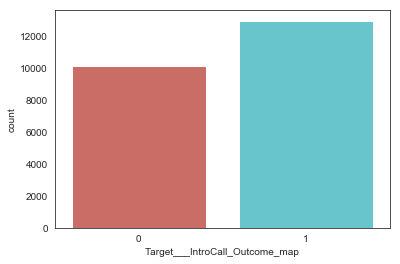

In [25]:
print("Qualfied (1) vs Disqualified Intro Calls (0)")
print("\n")
print(closedIntroCalls_Data.Target___IntroCall_Outcome_map.value_counts())
sns.countplot(x=closedIntroCalls_Data.Target___IntroCall_Outcome_map,data=closedIntroCalls_Data, palette='hls')
plt.show()

### Understanding Volumes of Qualified and DQ'd Intro Calls Over Time

Next I want to understand how the volume of intro calls has changed over time, both overall numbers and by qualification status (qualified vs disqualified).


The first graph below shows the volume of intro calls (min: ~ 0, high: ~50) versus their creation date (from Jan 2016 to Dec 2018). However the chart in its current state is difficult to discern for trends, so it might make sense to instead use a rolling mean.

One interesting trend to note is that there seemed to be a higher volume of closed intro calls between May 2017 and Jan 2018.

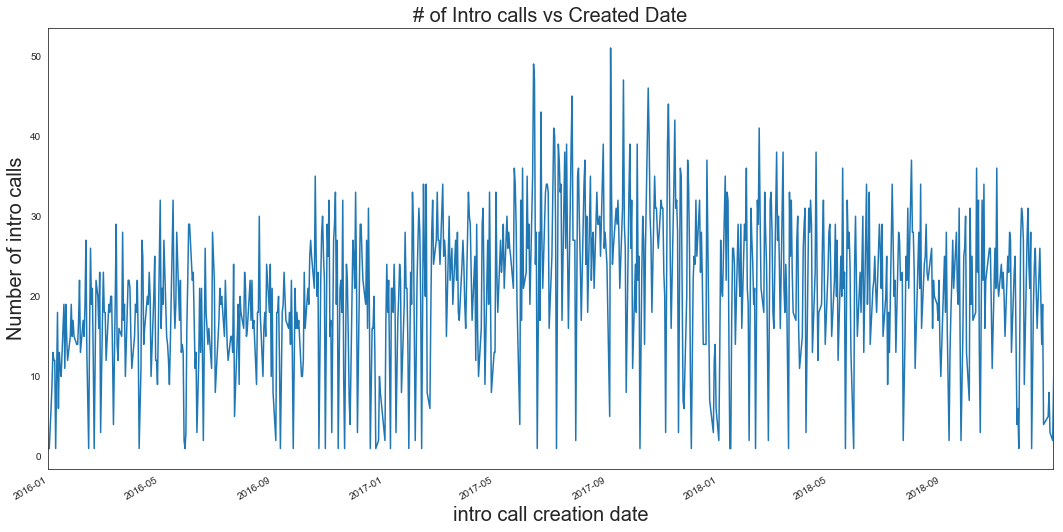

In [26]:
# Number of Intro Calls (both won and lost)

callsOverTime = closedIntroCalls_Data.groupby('createddate___IntroCall_ImportantSystemInfo_clean')['createddate___IntroCall_ImportantSystemInfo_clean'].count()
fig = plt.figure(figsize=(18, 9))
callsOverTime.plot()
plt.xlim([datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2018, 12, 31, 0, 0)])
plt.ylabel('Number of intro calls', fontsize = 20)
plt.xlabel('intro call creation date', fontsize = 20)
plt.title('# of Intro calls vs Created Date', fontsize = 20)
plt.show()

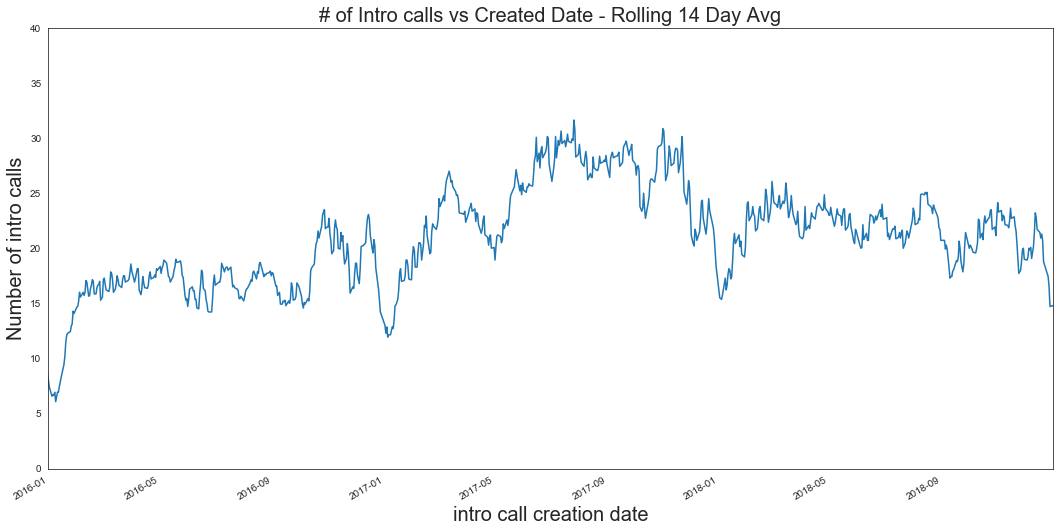

In [27]:
# Rolling 14 day avg 

callsOverTime = closedIntroCalls_Data.groupby('createddate___IntroCall_ImportantSystemInfo_clean')['createddate___IntroCall_ImportantSystemInfo_clean'].count().rolling(14).mean()
fig = plt.figure(figsize=(18, 9))
callsOverTime.plot()
plt.xlim([datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2018, 12, 31, 0, 0)])
plt.ylim([0,40])
plt.ylabel('Number of intro calls', fontsize = 20)
plt.xlabel('intro call creation date', fontsize = 20)
plt.title('# of Intro calls vs Created Date - Rolling 14 Day Avg', fontsize = 20)
plt.show()

But what we’re really interested in is understanding the drivers of qualified calls, so it makes sense to view the volume by time and qualification status. 

Red line is “unqualified”, blue line is “qualified”. It looks like volume has remained high in the last year but disqualifieds are making up a smaller proportion (possibly reinforcing the marketing team’s assertion that they’re providing higher quality leads). 

<Figure size 432x288 with 0 Axes>

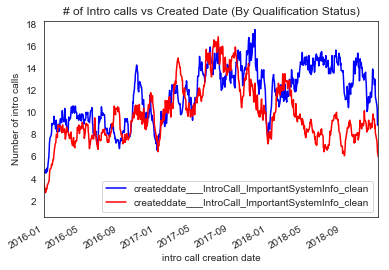

In [28]:
#'# of Intro calls vs Created Date (By Qualification Status)

qualifiedOverTime = closedIntroCalls_Data[closedIntroCalls_Data.Target___IntroCall_Outcome_map == 1].groupby('createddate___IntroCall_ImportantSystemInfo_clean')['createddate___IntroCall_ImportantSystemInfo_clean'].count().rolling(14).mean()
qualifiedOverTime = pd.DataFrame(qualifiedOverTime)

unqualifiedOverTime = closedIntroCalls_Data[closedIntroCalls_Data.Target___IntroCall_Outcome_map == 0].groupby('createddate___IntroCall_ImportantSystemInfo_clean')['createddate___IntroCall_ImportantSystemInfo_clean'].count().rolling(14).mean()
unqualifiedOverTime = pd.DataFrame(unqualifiedOverTime)


fig = plt.figure()
ax = qualifiedOverTime.plot(color='blue')
unqualifiedOverTime.plot(color='red',ax=ax)
plt.xlim([datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2018, 12, 31, 0, 0)])

plt.ylabel('Number of intro calls')
plt.xlabel('intro call creation date')
plt.title('# of Intro calls vs Created Date (By Qualification Status)')
plt.show()

### Understanding Demographics of Qualified and DQ'd Demos 


Next I want to understand the sources of the intro calls (like marketing channels, landing pages, business type, etc).

The charts 'Top 30 Lead Marketing Channels by Qualified’ are sorted by the count of qualified intro calls per traffic channel. 

What’s interesting is that even though some marketing channels have produced a large volume of qualifieds, they aren’t necessarily the same channels responsible for producing a high ratio of qualifieds to disqualifieds. 

For example, lead source 3 & 0 (corresponding to “Brand” and “Affiliate”) have a ratio of 1.9 but are in sixth place and up, with additional intro call sources in between having a ratio of around 0.8~1.6.  This is the first time I’ve seen the marketing funnel from the perspective of the intro calls (even within the company) so it’s fascinating to see the different levels of quality.

#### Traffic Channel 

   trafficChannel___Lead_MarketingInformation_map  notQ     Q  Ratio_QvNotQ
16                                        Unknown  1412  2442           1.7
13                                         Search  1488  2391           1.6
5                                Event/Conference  1062  1468           1.4
7                                        LinkedIn  1570  1414           0.9
10                                            PPC  1413  1283           0.9
6                                        Facebook  1195   942           0.8
3                                           Brand   300   557           1.9
18                                        Website   320   489           1.5
9                                        Outbound   217   338           1.6
2                                            Blog   132   231           1.8
15                                        Twitter   319   228           0.7
17                                           User   128   166           1.3
0           

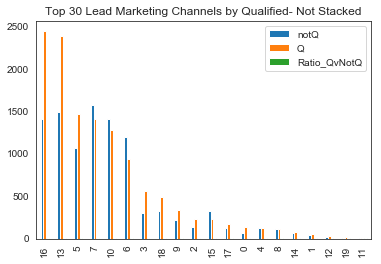

In [29]:
trafficChannel = closedIntroCalls_Data.groupby(['trafficChannel___Lead_MarketingInformation_map','Target___IntroCall_Outcome_map'])['PK_IntroCall_ID___IntroCall_ImportantIDInfo'].count()
trafficChannel = pd.DataFrame(trafficChannel)
trafficChannel.reset_index(inplace=True)

trafficChannel.columns = ['trafficChannel___Lead_MarketingInformation_map','Target___IntroCall_Outcome_map', 'counts']


table = pd.pivot_table(trafficChannel, values='counts', index='trafficChannel___Lead_MarketingInformation_map',columns=['Target___IntroCall_Outcome_map'], aggfunc=np.sum)
table = pd.DataFrame(table).fillna(0)
table.columns=['notQ','Q']
table.reset_index(inplace=True)
table['Ratio_QvNotQ'] = round(table['Q']/table['notQ'],1)

top30 = table.nlargest(30, 'Q')
print(top30)


top30.plot(kind='bar', stacked=False);
plt.ylabel('');
plt.xlabel('');
plt.title('Top 30 Lead Marketing Channels by Qualified- Not Stacked');
plt.show()

#### Customer Type

The next question I was trying to answer was whether the customer type could be a driver of qualified intro calls. 

After generating the following charts, it seems that customer type could be a driver (as well as an indicator of the company’s strategic focus on the enterprise space). 

1 corresponds to ‘Enterprise’ (2 is ‘Unknown’, which doesn’t exactly bode the best in terms of our data quality) and 4 corresponds to ‘Nonprofits’ (which makes sense, the company primarily markets to companies willing to invest significant resources in onboarding and digital adoption). 


  customerType___Lead_LeadCompanyInformation  notQ     Q  Ratio_QvNotQ
1                                 Enterprise  3244  4896           1.5
6                                    Unknown  2436  3190           1.3
2                                 Mid Market  1976  2341           1.2
5                                    Startup  1852  1721           0.9
3                                 Non Profit   373   277           0.7
4                                    Partner    76    64           0.8
0                            Biz Dev Partner    52    41           0.8


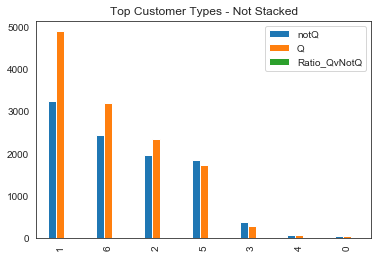

In [30]:
#Qualified and Unqualified calls by Customer Type

customerTypes = closedIntroCalls_Data.groupby(['customerType___Lead_LeadCompanyInformation','Target___IntroCall_Outcome_map'])['PK_IntroCall_ID___IntroCall_ImportantIDInfo'].count()
customerTypes = pd.DataFrame(customerTypes)
customerTypes.reset_index(inplace=True)

customerTypes.columns = ['customerType___Lead_LeadCompanyInformation','Target___IntroCall_Outcome_map', 'counts']


table = pd.pivot_table(customerTypes, values='counts', index='customerType___Lead_LeadCompanyInformation',columns=['Target___IntroCall_Outcome_map'], aggfunc=np.sum)
table = pd.DataFrame(table).fillna(0)
table.columns=['notQ','Q']
table.reset_index(inplace=True)
table['Ratio_QvNotQ'] = round(table['Q']/table['notQ'],1)

top30 = table.nlargest(30, 'Q')
print(top30)


top30.plot(kind='bar', stacked=False);
plt.ylabel('');
plt.xlabel('');
plt.title('Top Customer Types - Not Stacked');
plt.show()

#### Countries

Countries is a little surprising as we have some EMEA and ANZ/APAC countries listed as the top producers of qualified intro calls. The company started in Israel and has major presence in AMER but it’s interesting to see the UK (#111), Australia (#4), and Germany (#38) up in the top 8. 

    country___Lead_LeadCompanyInformation    notQ       Q  Ratio_QvNotQ
112                         United States  5533.0  7349.0           1.3
111                        United Kingdom   910.0  1031.0           1.1
16                                 Canada   579.0   663.0           1.1
4                               Australia   545.0   657.0           1.2
38                                Germany   222.0   291.0           1.3
50                                 Israel   193.0   217.0           1.1
36                                 France   124.0   213.0           1.7
72                            Netherlands   176.0   185.0           1.1
73                            New Zealand    84.0   117.0           1.4
47                                  India   145.0   107.0           0.7
101                           Switzerland    52.0   107.0           2.1
11                                Belgium    76.0    97.0           1.3
97                                  Spain    78.0    91.0       

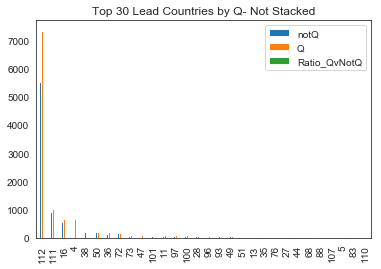

In [31]:
#Qualified and Unqualified calls by Country

countries = closedIntroCalls_Data.groupby(['country___Lead_LeadCompanyInformation','Target___IntroCall_Outcome_map'])['PK_IntroCall_ID___IntroCall_ImportantIDInfo'].count()
countries = pd.DataFrame(countries)
countries.reset_index(inplace=True)

countries.columns = ['country___Lead_LeadCompanyInformation','Target___IntroCall_Outcome_map', 'counts']


table = pd.pivot_table(countries, values='counts', index='country___Lead_LeadCompanyInformation',columns=['Target___IntroCall_Outcome_map'], aggfunc=np.sum)
table = pd.DataFrame(table).fillna(0)
table.columns=['notQ','Q']
table.reset_index(inplace=True)
table['Ratio_QvNotQ'] = round(table['Q']/table['notQ'],1)

top30 = table.nlargest(30, 'Q')
print(top30)


top30.plot(kind='bar', stacked=False);
plt.ylabel('');
plt.xlabel('');
plt.title('Top 30 Lead Countries by Q- Not Stacked');
plt.show()

#### Landing Page

When we look at landing pages and try to create top 30 charts, we see some interesting trends where the top 30 best landing pages by qualifieds count aren’t the same as the top 30 landing pages by ratio of qualified to disqualified intro calls. 

In [32]:
#Top Landing Pages by Qualified and Unqualified


lands = closedIntroCalls_Data.groupby(['landingPage___Lead_MarketingInformation','Target___IntroCall_Outcome_map'])['PK_IntroCall_ID___IntroCall_ImportantIDInfo'].count()
lands = pd.DataFrame(lands)
lands.reset_index(inplace=True)

lands.columns = ['landingPage___Lead_MarketingInformation','Target___IntroCall_Outcome_map', 'counts']


table = pd.pivot_table(lands, values='counts', index='landingPage___Lead_MarketingInformation',columns=['Target___IntroCall_Outcome_map'], aggfunc=np.sum)
table = pd.DataFrame(table).fillna(0)
table.columns=['notQ','Q']
table.reset_index(inplace=True)
table['Ratio_QvNotQ'] = round(table['Q']/table['notQ'],1)


top30Q = table.nlargest(30, 'Q')
print("Top 30 Landing Pages by Qualified Count")
top30Q

Top 30 Landing Pages by Qualified Count


,landingPage___Lead_MarketingInformation,notQ,Q,Ratio_QvNotQ
269,home,85.0,152.0,1.8
782,using-salesforce,109.0,141.0,1.3
247,employee-training-easier-st2-2,191.0,125.0,0.7
130,creating-online-tutorials,112.0,77.0,0.7
346,instantly-improve-ux,104.0,77.0,0.7
494,salesforce-never-easier,83.0,62.0,0.7
27,Omri-SF2,18.0,53.0,2.9
389,never-been-easy,47.0,50.0,1.1
240,employee-training-easier,82.0,49.0,0.6
740,tutorial-creation,90.0,46.0,0.5


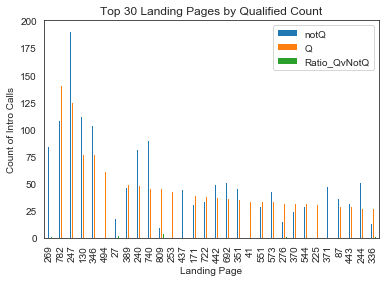

In [33]:
# Top 30 Landing Pages by Qualified Count

top30Q.plot(kind='bar', stacked=False);
plt.ylabel('Count of Intro Calls');
plt.xlabel('Landing Page');
plt.title('Top 30 Landing Pages by Qualified Count');
plt.show()

In [34]:
### Top 30 Landing Pages by DQ Count

top30DQ = table.nlargest(30, 'notQ')
print("Top 30 Landing Pages by Disqualified Count")
top30DQ

Top 30 Landing Pages by Disqualified Count


,landingPage___Lead_MarketingInformation,notQ,Q,Ratio_QvNotQ
247,employee-training-easier-st2-2,191.0,125.0,0.7
130,creating-online-tutorials,112.0,77.0,0.7
782,using-salesforce,109.0,141.0,1.3
346,instantly-improve-ux,104.0,77.0,0.7
253,employee-training-software,92.0,43.0,0.5
740,tutorial-creation,90.0,46.0,0.5
269,home,85.0,152.0,1.8
494,salesforce-never-easier,83.0,62.0,0.7
240,employee-training-easier,82.0,49.0,0.6
244,employee-training-easier-st1,52.0,28.0,0.5


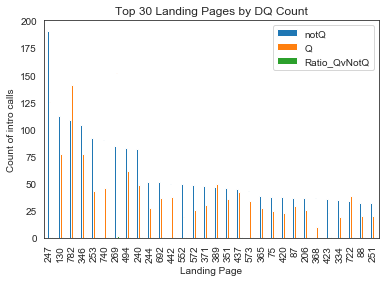

In [35]:
top30DQ.plot(kind='bar', stacked=False);
plt.ylabel('Count of intro calls');
plt.xlabel('Landing Page');
plt.title('Top 30 Landing Pages by DQ Count');
plt.show()

### Understanding Interactions of Quantitative Variables of Qualified and DQ'd Demos 

#### Lead Score vs Total Calls & Emails
Next I want to understand the relationship between the marketing stamped lead score and the total calls & emails logged against that lead. 


Generating the charts below, it’s surprising to see that the greater the lead score, the more engagement is needed for that lead. 


After separating out the qualified and disqualified intro calls we notice there are some outliers (especially in the Qualifieds chart), where a lead score (of around 20) had +35 emails and calls logged. We don’t want to just address that one point, however, but a way to systematically address outliers.

The following charts show outlier adjusted plots, where we can see a clearer relationship between qualified and disqualified intro calls. The trend is a bit more intuitive as we can imagine SDR’s and their workflows. 


For example, for qualified intro calls the relationship between total calls/emails and lead scores is less steep than for disqualified intro calls. In general the role of an SDR is to weed out the bad and keep hooked the good. For leads with higher lead scores, the positive slope could be showing that SDR’s will engage more with prospects they view as positive bets. 

With disqualified vs qualified intro calls it’s possible however that SDR’s could also be putting additional effort into “pulling people across the line” or setting calls with individuals that might not be a great fit and therefore need extra coaxing.

In [36]:
scoresVtot = closedIntroCalls_Data.copy() 
scoresVtot['totalCallsEmails'] = scoresVtot['totalCalls___Lead_AddedInfo'] + scoresVtot['totalEMails___Lead_AddedInfo'] 


scores = scoresVtot.groupby(['inferScore___Lead_AddedInfo','Target___IntroCall_Outcome_map'])['totalCallsEmails'].median()
scores = pd.DataFrame(scores)
scores.reset_index(inplace=True)
scores.head(30)

,inferScore___Lead_AddedInfo,Target___IntroCall_Outcome_map,totalCallsEmails
0,6.0,0,NaN
1,7.0,0,19.5
2,8.0,0,15.0
3,9.0,0,11.0
4,9.0,1,19.0
5,11.0,0,9.0
6,11.0,1,12.0
7,12.0,0,NaN
8,12.0,1,12.0
9,13.0,0,NaN


In [37]:
closedWonIntro = pd.DataFrame(scores[scores['Target___IntroCall_Outcome_map']>0])
closedWonIntro = closedWonIntro.replace(np.nan,0).dropna()
closedWonIntro = closedWonIntro[np.abs(closedWonIntro.totalCallsEmails-closedWonIntro.totalCallsEmails.mean()) <= (3*closedWonIntro.totalCallsEmails.std())]


closedLostIntro = pd.DataFrame(scores[scores['Target___IntroCall_Outcome_map']<1])
closedLostIntro = closedLostIntro.replace(np.nan,0).dropna()
closedLostIntro = closedLostIntro[np.abs(closedLostIntro.totalCallsEmails-closedLostIntro.totalCallsEmails.mean()) <= (3*closedLostIntro.totalCallsEmails.std())]


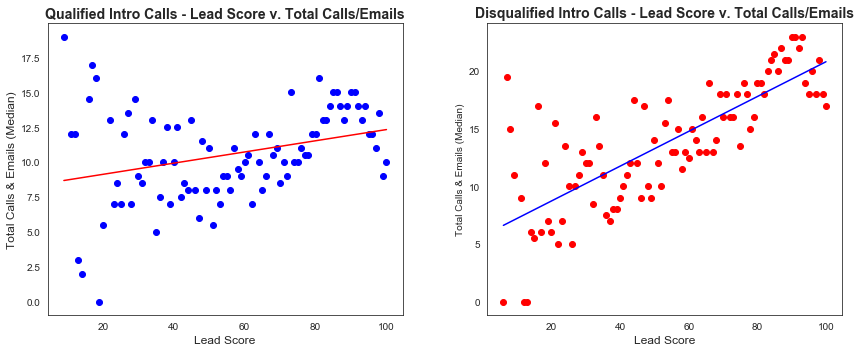

In [38]:


fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(closedWonIntro.inferScore___Lead_AddedInfo, closedWonIntro.totalCallsEmails, 'bo');
plt.ylabel('Total Calls & Emails (Median)', fontsize = 12);
plt.xlabel('Lead Score', fontsize = 12);
plt.title('Qualified Intro Calls - Lead Score v. Total Calls/Emails', fontsize = 14, fontweight = 'bold');

#Add regression line
slope, intercept, r, p, stderr = linregress(closedWonIntro.inferScore___Lead_AddedInfo, closedWonIntro.totalCallsEmails)
line_values = [slope * i + intercept for i in list(closedWonIntro.inferScore___Lead_AddedInfo)]
plt.plot(list(closedWonIntro.inferScore___Lead_AddedInfo), line_values, '-r');


plt.subplot(1,3,2)
plt.plot(closedLostIntro.inferScore___Lead_AddedInfo, closedLostIntro.totalCallsEmails, 'ro');
plt.ylabel('Total Calls & Emails (Median)');
plt.xlabel('Lead Score', fontsize = 12);
plt.title('Disqualified Intro Calls - Lead Score v. Total Calls/Emails', fontsize = 14, fontweight = 'bold');

#Add regression line
slope2, intercept2, r2, p2, stderr2 = linregress(closedLostIntro.inferScore___Lead_AddedInfo, closedLostIntro.totalCallsEmails)
line_values2 = [slope2 * i + intercept2 for i in list(closedLostIntro.inferScore___Lead_AddedInfo)]
plt.plot(list(closedLostIntro.inferScore___Lead_AddedInfo), line_values2, '-b');
fig.tight_layout()

#### Intro Call Created Delta vs Total Calls & Emails

In trying to analyze the relationship between “introCallCreated_leadCreated_delta” (days elapsed between when the lead was created and when the intro call was created i.e. when a lead hit our system and someone talked to them) and total calls/emails there seems to be a negative relationship. 


In [39]:
introDelt = closedIntroCalls_Data.copy() 
introDelt['totalCallsEmails'] = introDelt['totalCalls___Lead_AddedInfo'] + introDelt['totalEMails___Lead_AddedInfo'] 


introDeltVtot = introDelt.groupby(['introCallCreated_leadCreated_delta','Target___IntroCall_Outcome_map'])['totalCallsEmails'].mean()
introDeltVtot = pd.DataFrame(introDeltVtot)
introDeltVtot.reset_index(inplace=True)
introDeltVtot.head(30)

,introCallCreated_leadCreated_delta,Target___IntroCall_Outcome_map,totalCallsEmails
0,-569.0,1,1.000000
1,-83.0,1,NaN
2,-19.0,1,NaN
3,-14.0,1,NaN
4,-10.0,1,NaN
5,-6.0,1,1.000000
6,0.0,0,15.993316
7,0.0,1,10.063089
8,1.0,0,19.676471
9,1.0,1,12.520786


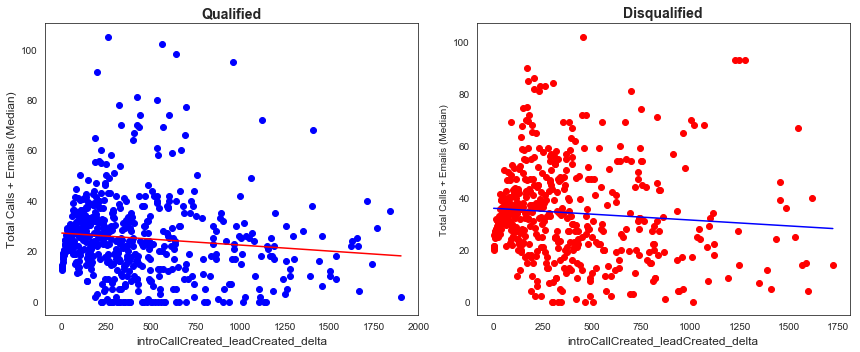

In [40]:
closedWonIntro = pd.DataFrame(introDeltVtot[introDeltVtot['Target___IntroCall_Outcome_map']>0])
closedWonIntro = closedWonIntro.replace(np.nan,0).dropna()
closedWonIntro = closedWonIntro[np.abs(closedWonIntro.totalCallsEmails-closedWonIntro.totalCallsEmails.mean()) <= (3*closedWonIntro.totalCallsEmails.std())]
closedWonIntro = closedWonIntro[closedWonIntro['introCallCreated_leadCreated_delta']>0]


closedLostIntro = pd.DataFrame(introDeltVtot[introDeltVtot['Target___IntroCall_Outcome_map']<1])
closedLostIntro = closedLostIntro.replace(np.nan,0).dropna()
closedLostIntro = closedLostIntro[np.abs(closedLostIntro.totalCallsEmails-closedLostIntro.totalCallsEmails.mean()) <= (3*closedLostIntro.totalCallsEmails.std())]
closedLostIntro = closedLostIntro[closedLostIntro['introCallCreated_leadCreated_delta']>0]




fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(closedWonIntro.introCallCreated_leadCreated_delta, closedWonIntro.totalCallsEmails, 'bo');
plt.ylabel('Total Calls + Emails (Median)', fontsize = 12);
plt.xlabel('introCallCreated_leadCreated_delta', fontsize = 12);
plt.title('Qualified', fontsize = 14, fontweight = 'bold');

#Add regression line
slope, intercept, r, p, stderr = linregress(closedWonIntro.introCallCreated_leadCreated_delta, closedWonIntro.totalCallsEmails)
line_values = [slope * i + intercept for i in list(closedWonIntro.introCallCreated_leadCreated_delta)]
plt.plot(list(closedWonIntro.introCallCreated_leadCreated_delta), line_values, '-r');


plt.subplot(1,3,2)
plt.plot(closedLostIntro.introCallCreated_leadCreated_delta, closedLostIntro.totalCallsEmails, 'ro');
plt.ylabel('Total Calls + Emails (Median)');
plt.xlabel('introCallCreated_leadCreated_delta', fontsize = 12);
plt.title('Disqualified', fontsize = 14, fontweight = 'bold');

#Add regression line
slope2, intercept2, r2, p2, stderr2 = linregress(closedLostIntro.introCallCreated_leadCreated_delta, closedLostIntro.totalCallsEmails)
line_values2 = [slope2 * i + intercept2 for i in list(closedLostIntro.introCallCreated_leadCreated_delta)]
plt.plot(list(closedLostIntro.introCallCreated_leadCreated_delta), line_values2, '-b');
fig.tight_layout()

I’d like to further investigate the following variables as potential candidates for drivers of intro call status:

* Landing Page 
* Lead/Marketing Channel
* Customer Type
* Creation Date


I’m ambivalent about the following variables given the mixed results I’ve seen in the previous charts:

* Lead Score
* Intro Call - Lead Creation Delta
* Region

I’m interested in seeing which of these variables end up being major contributors to the predictive models I’ll be generating. Within the company we have a lot of untested beliefs about what drives a successful sales and being able to test out some of these assumptions will be incredibly helpful. 

One belief we have internally that can’t be tested directly (but could be indirectly) is that different sales teams have drastically different close rates. The difficulty in trying to test that question is the company has completely restructured the sales teams in the last 4-6 years and we don’t have historical data on which individuals were on which teams handling specific deals. For the most part teams have been split across geographic territories so one way to determine if some teams (or regions) were more effective is analyzing the impact of geography on the qualification rates.  

Another belief we have is that lead with higher lead scores should perform better and require less handholding.

In the following section I want to further dive in and understand whether there are meaningful differences between disqualified and qualified intro calls. 

In [41]:
closedIntroCalls_Data['totalCallsEmails'] = closedIntroCalls_Data['totalEMails___Lead_AddedInfo'] + closedIntroCalls_Data['totalEMails___Lead_AddedInfo'] 

### Testing for Meaningful Differences between Qualified & Disqualified Intro Calls

From previous exploration with this data set we have the following intuition:

* Lead Score vs. Total Calls/Emails
> Higher lead scores for disqualified intro calls were accompanied by more engagement (Total Calls + Emails), while Qualified Intro Calls showed a flatter relationship.  

* Time Delta Between Lead & Intro Call Creation vs. Target Outcome
> Qualified and Unqualified Intro Calls showed similar relationships between Time Delta and Total Calls & Emails. 

From experience with the business context of the project, additional assumptions should be tested:


* Lead Scores vs. Target Outcome - 
> * There should be no difference in average scores between two groups (and scores should be concentrated between 80-90, with no leads with scores below 60) because marketing claimed to automatically reject leads with a grade of D or below (which should correspond to a lead score of 60).

* Total Calls & Emails vs. Target Outcome - 
> * We could see potentially two opposing trends at work, with regards to level of engagement with the prospect and their suitability for sales. 
> * We could a positive relationship between amount of engagement for unqualified candidates (where sales reps need to exert additional effort to pull them further into the sales cycle). 
> * We could see a negative relationship between level of engagement (via Total Calls & Emails) for qualified prospects (higher quality due to greater suitability or interest, so less effort needed to pull the prospect into the sales cycle). 
> * We could also see a positive relationship where savvy, highly engaged shoppers are requiring more engagement from our sales teams through follow-up questions and due diligence. 

* Time Delta Between Lead & Intro Call Creation vs. Target Outcome
> * Freshness is an important concept in sales and the common intuition is the longer the sales cycle takes (assuming same resulting payoffs), the less likely a prospect will stay engaged in the sales cycle. 


By using both frequentist and randomized approaches, we can understand how significantly different the means are between the groups (by Target Outcome) and whether these differences could be explained through chance. 


#### Lead Scores vs. Qualification Status

We first want to understand the summary statistics of Qualified vs. Unqualified Intro Calls and whether the assertion that there is no difference (and lead scores should be 60+).

* From printing the summary statistics, we can already see that the assertion that the sales team doesn’t interact with leads below 60 is false. Both samples of Qualified and Disqualified Intro Calls had a minimum below 60 (Qualified: 9, Disqualified: 6). 
* However our Qualified sample is displaying an IQR of [82 (25%), 92 (75%)] and our Disqualified sample is displaying an IQR of [73 (25%), 91 (75%)], so it’s possible the assertion that the majority of leads leading to demo calls should be around 70-90. We also observe a difference in means: Qualified (84), Unqualified (80).   


Summary of Qualified Intro Calls:         inferScore___Lead_AddedInfo
count                 10206.000000
mean                     84.197727
std                      13.998401
min                       9.000000
25%                      82.000000
50%                      90.000000
75%                      92.000000
max                     100.000000


Summary of Not Qualified Intro Calls:         inferScore___Lead_AddedInfo
count                  9839.000000
mean                     79.399228
std                      17.702764
min                       6.000000
25%                      73.000000
50%                      88.000000
75%                      91.000000
max                     100.000000


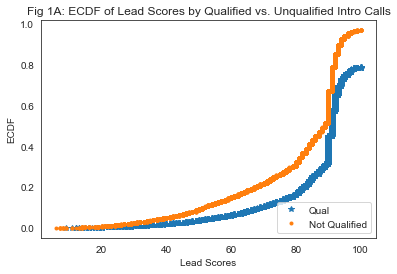

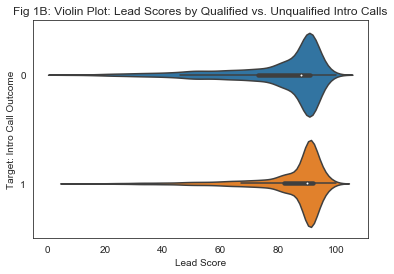

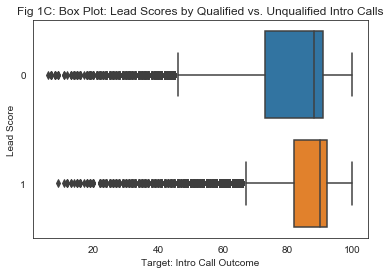

In [42]:
### Lead Score

closedWonIntro = closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==1]
closedLostIntro = closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==0]



normSample = np.random.normal(np.mean(closedIntroCalls_Data.inferScore___Lead_AddedInfo), np.std(closedIntroCalls_Data.inferScore___Lead_AddedInfo), size=100000)


print("Summary of Qualified Intro Calls: ", closedWonIntro[['inferScore___Lead_AddedInfo']].describe())
print("\n")
print("Summary of Not Qualified Intro Calls: ", closedLostIntro[['inferScore___Lead_AddedInfo']].describe())


# Compute ECDFs
x_qual, y_qual = ecdf(closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==1].inferScore___Lead_AddedInfo)
x_notQual, y_notQual = ecdf(closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==0].inferScore___Lead_AddedInfo)




# Plot all ECDFs on the same plot
_ = plt.plot(x_qual, y_qual, marker = '*', linestyle = 'none')
_ = plt.plot(x_notQual, y_notQual, marker = '.', linestyle = 'none')


# Annotate the plot
plt.legend(('Qual', 'Not Qualified'), loc='lower right')
_ = plt.xlabel('Lead Scores')
_ = plt.ylabel('ECDF')
_ = plt.title('Fig 1A: ECDF of Lead Scores by Qualified vs. Unqualified Intro Calls')

# Display the plot
plt.show()

# Create bee swarm plot
fig2 = sns.violinplot(x='inferScore___Lead_AddedInfo',y='Target___IntroCall_Outcome_map',data=closedIntroCalls_Data, scale='count',orient='h')

# Label the axes
fig2 = plt.xlabel('Lead Score')
fig2 = plt.ylabel('Target: Intro Call Outcome')
fig2 = plt.title('Fig 1B: Violin Plot: Lead Scores by Qualified vs. Unqualified Intro Calls')

# Show the plot
plt.show()


# Create box plot with Seaborn's default settings
fig3 = sns.boxplot(y='Target___IntroCall_Outcome_map',x='inferScore___Lead_AddedInfo',data=closedIntroCalls_Data, orient='h')

# Label the axes
fig3 =plt.xlabel('Target: Intro Call Outcome')
fig3 =plt.ylabel('Lead Score')
fig3 = plt.title('Fig 1C: Box Plot: Lead Scores by Qualified vs. Unqualified Intro Calls')


# Show the plot
plt.show()

I created charts showing the empirical cumulative distribution function (Fig 1A), the distribution of lead scores (Fig 1B), and a box-plot displaying the summary statistics (Fig 1C) in order to further understand the distributions of lead scores. 

* [Fig 1A] We can see from the ECDF that both groups experience a pick up at Lead Score ~ 80, where a relatively larger proportion of prospects exist. However our sample of Disqualified Intro Calls shows a relatively higher proportion of leads between 40 and 90.


* [Fig 1B] Each violin plot is scaled by count. We can see that the samples are roughly the same size, seem to have medians concentrated around ~90 (visually confirm the summary statistics we printed earlier), and both are left skewed. The Unqualified Lead Scores (Target Outcome = 0) sample also has a fatter peak and more observations in the 60 & below range (as shown by the fatter tail).    


* [Fig 1C] We can see that the Unqualified Lead Scores potentially display higher variance and have lower lead scores at the 25%.   


* [Fig 1D] The histogram of permuted replicates below shows how extreme a value of 4.8 is relative to expectation if the populations had been the same.

Qualified Intro Calls (Lead Score):      inferScore___Lead_AddedInfo
1                          90.0
5                          92.0
7                          90.0
8                          91.0
9                          83.0
12                         60.0
13                         91.0
14                         91.0
15                         92.0
16                         94.0
17                         90.0
18                         92.0
19                         90.0
20                         91.0
21                         80.0
23                         84.0
26                         91.0
27                        100.0
29                         90.0
32                         87.0

 
 

Disqualified Intro Calls (Lead Score):      inferScore___Lead_AddedInfo
0                          92.0
4                          90.0
10                         90.0
11                         91.0
24                         91.0
28                         90.0
30                   

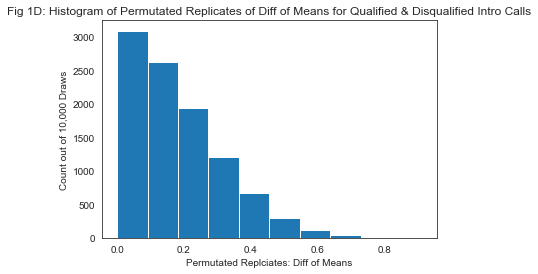


 
 

Proportion of replicates with value as great or greater than empirical diff of means
p-value = 0.0000


In [43]:
# Hypothesis 1: Permutation Test - 
# Simulating the null hypothesis that the two variables have identical distributions
# Measuring the difference between resulting calculated means to understand how much the
# resulting difference would shift compared to the empirical difference between original groups
# If there is no measureable difference, then reshuffling of labels should be arbitrary

# p-value in this case is measuring the proportion of replicates that have as 
# big a value as the empirical diff (or greater)
# Statistically significant p-value is low
# i.e. whether it falls into the tails of the empirically derived sampling distribution 

# Compute difference of mean impact force from experiment: empirical_diff_means

force_a = closedWonIntro[['inferScore___Lead_AddedInfo']]
force_a = force_a.dropna()

force_b = closedLostIntro[['inferScore___Lead_AddedInfo']]
force_b = force_b.dropna()

print("Qualified Intro Calls (Lead Score): ", force_a.head(20))
print("\n \n \n")
print("Disqualified Intro Calls (Lead Score): ", force_b.head(20))

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

print("\n \n \n")
print("Empirical Diff of Mean:", empirical_diff_means)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates= draw_perm_reps(force_a, force_b, diff_of_means, size=10000)


print("\n")

fig4 = plt.hist(perm_replicates)
fig4 = plt.xlabel('Permutated Replciates: Diff of Means')
fig4 = plt.ylabel('Count out of 10,000 Draws')
fig4 = plt.title('Fig 1D: Histogram of Permutated Replicates of Diff of Means for Qualified & Disqualified Intro Calls')


plt.show()


# Compute p-value: p
p = len(perm_replicates[perm_replicates >= empirical_diff_means]) / len(perm_replicates)

# Print the result
print("\n \n \n")
print("Proportion of replicates with value as great or greater than empirical diff of means")
print('p-value = %.4f' % p)



The histogram of bootstrap replicates below shows how extreme a value of 4.8 is relative to expectation if the populations had been the same (Fig 1F).




Concatenated Qualified & Disqualified Data: [[90.]
 [92.]
 [90.]
 ...
 [92.]
 [90.]
 [83.]]


Mean Values of Concatenated Data:  81.84240458967324


Qualified Intro Call Shifted:      inferScore___Lead_AddedInfo
1                     87.644678
5                     89.644678
7                     87.644678
8                     88.644678
9                     80.644678
12                    57.644678
13                    88.644678
14                    88.644678
15                    89.644678
16                    91.644678


Disqualified Intro Call Shifted:      inferScore___Lead_AddedInfo
0                     94.443177
4                     92.443177
10                    92.443177
11                    93.443177
24                    93.443177
28                    92.443177
30                    92.443177
31                    86.443177
33                    88.443177
35                    92.443177


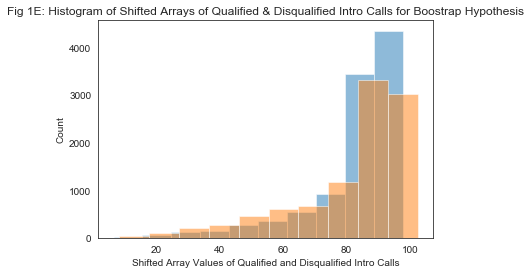


 

Qualified Intro Call Boostrap Replicates:  [81.79782297 81.87326879 81.80282003 ... 81.94587314 82.04062132
 81.59921431]


Disqualified Intro Call Boostrap Replicates:  [81.76383969 81.74269934 81.91863185 ... 82.05370655 82.20250216
 82.15605435]

 
 

Proportion of replicates with value as great or greater than empirical diff of means
p-value = 0.0000


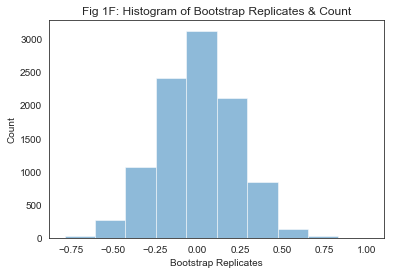

In [44]:
# Hypothesis 2: Two Sample Bootstrap Hypothesis Test for Differences of Means - 

# Simulating the null hypothesis that the two variables are the same 
# but belong to two different distributions. 
# Shift both arrays of data to have the same mean and generate boostrap replicates 
# (draw samples from shifted arrays & compute the difference in means)


# Measuring the difference between resulting calculated means to understand how much the
# resulting difference would shift compared to the empirical difference between original groups


# p-value in this case is measuring the proportion of replicates with a difference in means 
#greater than or equal to observed via the empirrical diff of means




# Compute mean of all forces: mean_force

forces_concat = pd.concat([force_a, force_b])
forces_concat = np.array(forces_concat)

print("\n")
print("Concatenated Qualified & Disqualified Data:", forces_concat)

mean_force = np.mean(forces_concat)
print("\n")
print("Mean Values of Concatenated Data: ", mean_force)


# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

print("\n")
print("Qualified Intro Call Shifted: ", force_a_shifted.head(10))
print("\n")
print("Disqualified Intro Call Shifted: ", force_b_shifted.head(10))

force_a_shifted = np.array(force_a_shifted)
force_b_shifted = np.array(force_b_shifted)

fig5 = plt.hist(force_a_shifted, alpha=0.5)
fig5 = plt.hist(force_b_shifted, alpha=0.5)

fig5 = plt.xlabel('Shifted Array Values of Qualified and Disqualified Intro Calls')
fig5 = plt.ylabel('Count')
fig5 = plt.title('Fig 1E: Histogram of Shifted Arrays of Qualified & Disqualified Intro Calls for Boostrap Hypothesis')


plt.show()

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, size=10000)

print("\n \n")
print("Qualified Intro Call Boostrap Replicates: ", bs_replicates_a)

print("\n")
print("Disqualified Intro Call Boostrap Replicates: ", bs_replicates_b)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)


print("\n \n \n")
print("Proportion of replicates with value as great or greater than empirical diff of means")
print('p-value = %.4f' % p)

fig6 = plt.hist(bs_replicates, alpha=0.5)
fig6 = plt.xlabel('Bootstrap Replicates')
fig6 = plt.ylabel('Count')
fig6 = plt.title('Fig 1F: Histogram of Bootstrap Replicates & Count')

plt.show()

In [45]:
#Using Mann-Whitney Test & Wlech's t-test

print(stats.mannwhitneyu(force_a, force_b))

print(stats.ttest_ind(force_a, force_b, equal_var = False))

MannwhitneyuResult(statistic=41233671.0, pvalue=1.3146576841498825e-107)
Ttest_indResult(statistic=array([21.23737118]), pvalue=array([6.33020917e-99]))


Both the Mann-Whitney test and Welch’s T-Test seem to also support rejecting the null hypothesis that the means are the same. 

#### Total Calls/Emails vs. Qualification Status

The first step in analyzing the possible relationship between Total Calls & Emails on Target outcome is to examine the summary statistics and note differences in mean, median, min/max.
In an ideal sales world, most sales managers would like sales reps to engage in the minimum amount of correspondence needed to: (1) qualify a prospect and (2) ensure good prospects are pulled into the sales process.  

* From printing the summary statistics, we can already see that Disqualified Intro Calls were associated with a higher mean of Total Calls & Emails compared to Qualified Intro Calls (36.9 vs. 28.0). 


* We can also see a difference in the IQR of Disqualified vs Qualified Intro Calls, indicating that prospects of Disqualified Intro Calls could be taking up more sales rep time (Qualified: [12 (25%), 40 (75%)], Disqualified: [14 (25%), 52 (75%)]). ] 


Qualified:         totalCallsEmails
count       7047.000000
mean          28.208599
std           21.519939
min            0.000000
25%           12.000000
50%           24.000000
75%           40.000000
max          100.000000


Not Qualified:         totalCallsEmails
count       6912.000000
mean          37.053241
std           29.304731
min            0.000000
25%           14.000000
50%           30.000000
75%           52.000000
max          138.000000


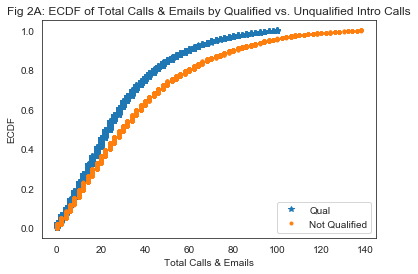

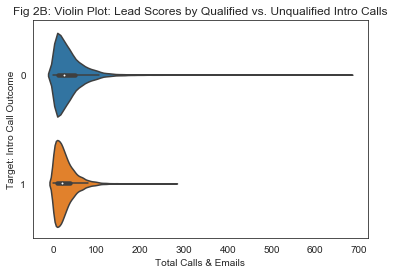

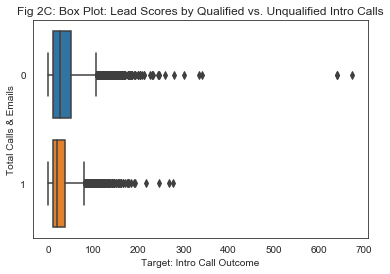

In [46]:
### Total Calls Emails

closedWonIntro = closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==1]
closedWonIntro = closedWonIntro[np.abs(closedWonIntro.totalCallsEmails-closedWonIntro.totalCallsEmails.mean()) <= (3*closedWonIntro.totalCallsEmails.std())]
closedWonIntro = closedWonIntro[closedWonIntro['introCallCreated_leadCreated_delta']>0]

closedLostIntro = closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==0]
closedLostIntro = closedLostIntro[np.abs(closedLostIntro.totalCallsEmails-closedLostIntro.totalCallsEmails.mean()) <= (3*closedLostIntro.totalCallsEmails.std())]
closedLostIntro = closedLostIntro[closedLostIntro['introCallCreated_leadCreated_delta']>0]



print("Qualified: ", closedWonIntro[['totalCallsEmails']].describe())
print("\n")
print("Not Qualified: ", closedLostIntro[['totalCallsEmails']].describe())


# Compute ECDFs
x_qual, y_qual = ecdf(closedWonIntro.totalCallsEmails)
x_notQual, y_notQual = ecdf(closedLostIntro.totalCallsEmails)




# Plot all ECDFs on the same plot
_ = plt.plot(x_qual, y_qual, marker = '*', linestyle = 'none')
_ = plt.plot(x_notQual, y_notQual, marker = '.', linestyle = 'none')


# Annotate the plot
plt.legend(('Qual', 'Not Qualified'), loc='lower right')
_ = plt.xlabel('Total Calls & Emails')
_ = plt.ylabel('ECDF')
_ = plt.title('Fig 2A: ECDF of Total Calls & Emails by Qualified vs. Unqualified Intro Calls')

# Display the plot
plt.show()


# Create bee swarm plot
fig2 = sns.violinplot(x='totalCallsEmails',y='Target___IntroCall_Outcome_map',data=closedIntroCalls_Data, scale='count',orient='h')

# Label the axes
fig2 = plt.xlabel('Total Calls & Emails')
fig2 = plt.ylabel('Target: Intro Call Outcome')
fig2 = plt.title('Fig 2B: Violin Plot: Lead Scores by Qualified vs. Unqualified Intro Calls')

# Show the plot
plt.show()


# Create box plot with Seaborn's default settings
fig3 = sns.boxplot(y='Target___IntroCall_Outcome_map',x='totalCallsEmails',data=closedIntroCalls_Data, orient='h')

# Label the axes
fig3 =plt.xlabel('Target: Intro Call Outcome')
fig3 =plt.ylabel('Total Calls & Emails')
fig3 = plt.title('Fig 2C: Box Plot: Lead Scores by Qualified vs. Unqualified Intro Calls')


# Show the plot
plt.show()


Similarly to Analysis Part 1, I visually examine the sample distributions further.

* [Fig 2A] Looking at the ECDF’s we can see that 60% of Qualified Intro Calls were associated with =<~30 Total Calls & Emails while the same % of Disqualified Intro Calls were associated with  =< ~40 Total Calls & Emails.


* [Fig 2B] Another trend we can observe (from both the violin plot and the summary statistics printout) is the presence of significant outliers in the Disqualified sample of Total Calls & Emails.       	    


* [Fig 2C] We can also verify in the boxplot the wider IQR, mostly due to the 75 percentile of data being shifted to the right (i.e. towards higher Total Calls & Emails) with two incredibly extreme outliers (~600+ Emails & Calls!)


* [Fig 2D] The histogram of permuted replicates below shows how extreme a value of 9.0 is relative to expectation if the populations had been the same.

Qualified Intro Calls (Total Calls Emails):      totalCallsEmails
1               46.0
5               28.0
7               50.0
12               8.0
13              44.0
14              48.0
16              30.0
17              72.0
18              90.0
20              38.0
21              44.0
23              60.0
26              14.0
27              16.0
29              44.0
32              24.0
40              42.0
44              16.0
49              12.0
52              50.0

 
 

Disqualified Intro Calls (Total Calls Emails):      totalCallsEmails
0               34.0
4               42.0
10              46.0
11              78.0
24              62.0
30              98.0
31              82.0
35              24.0
36              20.0
37              18.0
39             136.0
42              94.0
48              30.0
50              64.0
54              22.0
58              64.0
61              70.0
62              30.0
65              60.0
68              62.0

 
 

Empirical Dif

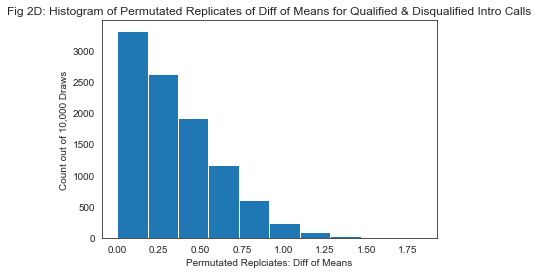


 
 

Proportion of replicates with value as great or greater than empirical diff of means
p-value = 0.0000


In [47]:
# Hypothesis 1: Permutation Test - 
# Simulating the null hypothesis that the two variables have identical distributions
# Measuring the difference between resulting calculated means to understand how much the
# resulting difference would shift compared to the empirical difference between original groups
# If there is no measureable difference, then reshuffling of labels should be arbitrary

# p-value in this case is measuring the proportion of replicates that have as 
# big a value as the empirical diff (or greater)
# Statistically significant p-value is low
# i.e. whether it falls into the tails of the empirically derived sampling distribution 

# Compute difference of mean impact force from experiment: empirical_diff_means

force_a = closedWonIntro[['totalCallsEmails']]
force_a = force_a.dropna()

force_b = closedLostIntro[['totalCallsEmails']]
force_b = force_b.dropna()

print("Qualified Intro Calls (Total Calls Emails): ", force_a.head(20))
print("\n \n \n")
print("Disqualified Intro Calls (Total Calls Emails): ", force_b.head(20))

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

print("\n \n \n")
print("Empirical Diff of Mean:", empirical_diff_means)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates= draw_perm_reps(force_a, force_b, diff_of_means, size=10000)


print("\n")

fig4 = plt.hist(perm_replicates)
fig4 = plt.xlabel('Permutated Replciates: Diff of Means')
fig4 = plt.ylabel('Count out of 10,000 Draws')
fig4 = plt.title('Fig 2D: Histogram of Permutated Replicates of Diff of Means for Qualified & Disqualified Intro Calls')


plt.show()


# Compute p-value: p
p = len(perm_replicates[perm_replicates >= empirical_diff_means]) / len(perm_replicates)

# Print the result
print("\n \n \n")
print("Proportion of replicates with value as great or greater than empirical diff of means")
print('p-value = %.4f' % p)

[Fig 2F] The histogram of bootstrap replicates below shows how extreme a value of 9.0 is relative to expectation if the populations had been the same.



Concatenated Qualified & Disqualified Data: [[ 46.]
 [ 28.]
 [ 50.]
 ...
 [134.]
 [ 46.]
 [ 52.]]


Mean Values of Concatenated Data:  32.58815101368293


Qualified Intro Call Shifted:      totalCallsEmails
1          50.379552
5          32.379552
7          54.379552
12         12.379552
13         48.379552
14         52.379552
16         34.379552
17         76.379552
18         94.379552
20         42.379552


Disqualified Intro Call Shifted:      totalCallsEmails
0           29.53491
4           37.53491
10          41.53491
11          73.53491
24          57.53491
30          93.53491
31          77.53491
35          19.53491
36          15.53491
37          13.53491


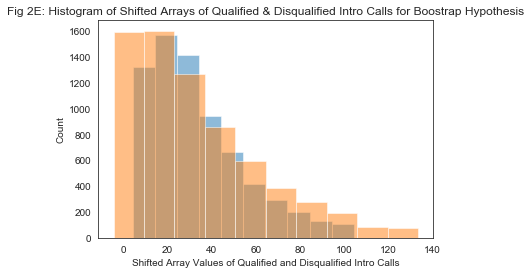


 

Qualified Intro Call Boostrap Replicates:  [32.42609624 32.65030512 32.16612746 ... 32.52060454 32.25268912
 32.31626227]


Disqualified Intro Call Boostrap Replicates:  [32.9614149  33.1561487  32.8123987  ... 33.20475981 32.46980611
 32.30603296]

 
 

Proportion of replicates with value as great or greater than empirical diff of means
p-value = 0.0000


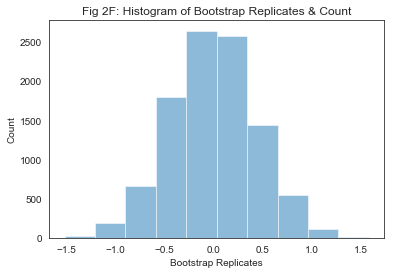

In [48]:
# Hypothesis 2: Two Sample Bootstrap Hypothesis Test for Differences of Means - 

# Simulating the null hypothesis that the two variables are the same 
# but belong to two different distributions. 
# Shift both arrays of data to have the same mean and generate boostrap replicates 
# (draw samples from shifted arrays & compute the difference in means)


# Measuring the difference between resulting calculated means to understand how much the
# resulting difference would shift compared to the empirical difference between original groups


# p-value in this case is measuring the proportion of replicates with a difference in means 
#greater than or equal to observed via the empirrical diff of means




# Compute mean of all forces: mean_force

forces_concat = pd.concat([force_a, force_b])
forces_concat = np.array(forces_concat)

print("\n")
print("Concatenated Qualified & Disqualified Data:", forces_concat)

mean_force = np.mean(forces_concat)
print("\n")
print("Mean Values of Concatenated Data: ", mean_force)


# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

print("\n")
print("Qualified Intro Call Shifted: ", force_a_shifted.head(10))
print("\n")
print("Disqualified Intro Call Shifted: ", force_b_shifted.head(10))

force_a_shifted = np.array(force_a_shifted)
force_b_shifted = np.array(force_b_shifted)

fig5 = plt.hist(force_a_shifted, alpha=0.5)
fig5 = plt.hist(force_b_shifted, alpha=0.5)

fig5 = plt.xlabel('Shifted Array Values of Qualified and Disqualified Intro Calls')
fig5 = plt.ylabel('Count')
fig5 = plt.title('Fig 2E: Histogram of Shifted Arrays of Qualified & Disqualified Intro Calls for Boostrap Hypothesis')


plt.show()

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, size=10000)

print("\n \n")
print("Qualified Intro Call Boostrap Replicates: ", bs_replicates_a)

print("\n")
print("Disqualified Intro Call Boostrap Replicates: ", bs_replicates_b)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)


print("\n \n \n")
print("Proportion of replicates with value as great or greater than empirical diff of means")
print('p-value = %.4f' % p)

fig6 = plt.hist(bs_replicates, alpha=0.5)
fig6 = plt.xlabel('Bootstrap Replicates')
fig6 = plt.ylabel('Count')
fig6 = plt.title('Fig 2F: Histogram of Bootstrap Replicates & Count')

plt.show()

In [49]:
#Using Mann-Whitney Test & Wlech's t-test

print(stats.mannwhitneyu(force_a, force_b))

print(stats.ttest_ind(force_a, force_b, equal_var = False))

MannwhitneyuResult(statistic=20558854.5, pvalue=1.3737176121758953e-57)
Ttest_indResult(statistic=array([-20.2931374]), pvalue=array([3.96766242e-90]))


Both the Mann-Whitney test and Welch’s T-Test seem to also support rejecting the null hypothesis that the means are the same.

#### Lead Created Delta vs. Qualification Status

As written previously, lead freshness is an important concept in sales and we could expect to see Disqualified Intro Calls associated with higher Time Deltas. 

* On average however, Qualified Intro Calls have higher means (39 days) than Disqualified Intro Calls (30 days). 


Qualified:         introCallCreated_leadCreated_delta
count                         9034.000000
mean                            30.620213
std                             62.332849
min                              1.000000
25%                              2.000000
50%                              7.000000
75%                             25.000000
max                            420.000000


Not Qualified:         introCallCreated_leadCreated_delta
count                         7551.000000
mean                            29.326050
std                             56.545029
min                              1.000000
25%                              3.000000
50%                              8.000000
75%                             28.000000
max                            394.000000


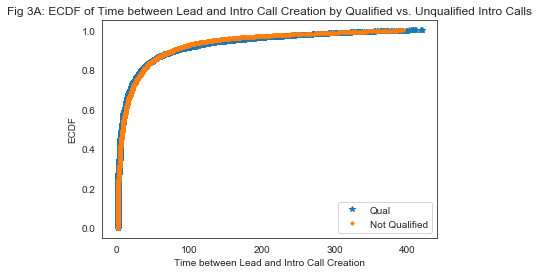

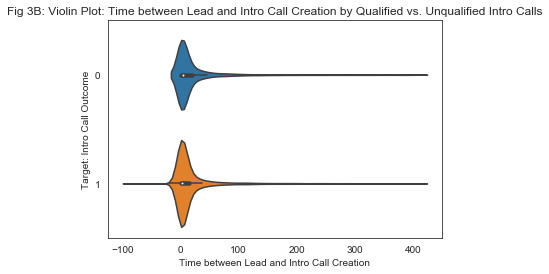

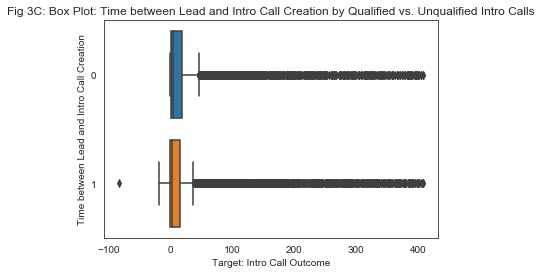

In [50]:
### Lead Created Delta

closedWonIntro = closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==1]
closedWonIntro = closedWonIntro[np.abs(closedWonIntro.introCallCreated_leadCreated_delta-closedWonIntro.introCallCreated_leadCreated_delta.mean()) <= (3*closedWonIntro.introCallCreated_leadCreated_delta.std())]
closedWonIntro = closedWonIntro[closedWonIntro['introCallCreated_leadCreated_delta']>0]

closedLostIntro = closedIntroCalls_Data[closedIntroCalls_Data['Target___IntroCall_Outcome_map']==0]
closedLostIntro = closedLostIntro[np.abs(closedLostIntro.introCallCreated_leadCreated_delta-closedLostIntro.introCallCreated_leadCreated_delta.mean()) <= (3*closedLostIntro.introCallCreated_leadCreated_delta.std())]
closedLostIntro = closedLostIntro[closedLostIntro['introCallCreated_leadCreated_delta']>0]

closedIntroCalls_Data = closedIntroCalls_Data[np.abs(closedIntroCalls_Data.introCallCreated_leadCreated_delta-closedIntroCalls_Data.introCallCreated_leadCreated_delta.mean()) <= (3*closedIntroCalls_Data.introCallCreated_leadCreated_delta.std())]

print("Qualified: ", closedWonIntro[['introCallCreated_leadCreated_delta']].describe())
print("\n")
print("Not Qualified: ", closedLostIntro[['introCallCreated_leadCreated_delta']].describe())


# Compute ECDFs
x_qual, y_qual = ecdf(closedWonIntro.introCallCreated_leadCreated_delta)
x_notQual, y_notQual = ecdf(closedLostIntro.introCallCreated_leadCreated_delta)


# Plot all ECDFs on the same plot
_ = plt.plot(x_qual, y_qual, marker = '*', linestyle = 'none')
_ = plt.plot(x_notQual, y_notQual, marker = '.', linestyle = 'none')



# Annotate the plot
plt.legend(('Qual', 'Not Qualified'), loc='lower right')
_ = plt.xlabel('Time between Lead and Intro Call Creation')
_ = plt.ylabel('ECDF')
_ = plt.title('Fig 3A: ECDF of Time between Lead and Intro Call Creation by Qualified vs. Unqualified Intro Calls')

# Display the plot
plt.show()


# Create bee swarm plot
fig2 = sns.violinplot(x='introCallCreated_leadCreated_delta',y='Target___IntroCall_Outcome_map',data=closedIntroCalls_Data, scale='count',orient='h')

# Label the axes
fig2 = plt.xlabel('Time between Lead and Intro Call Creation')
fig2 = plt.ylabel('Target: Intro Call Outcome')
fig2 = plt.title('Fig 3B: Violin Plot: Time between Lead and Intro Call Creation by Qualified vs. Unqualified Intro Calls')

# Show the plot
plt.show()



# Create box plot with Seaborn's default settings
fig3 = sns.boxplot(y='Target___IntroCall_Outcome_map',x='introCallCreated_leadCreated_delta',data=closedIntroCalls_Data, orient='h')

# Label the axes
fig3 =plt.xlabel('Target: Intro Call Outcome')
fig3 =plt.ylabel('Time between Lead and Intro Call Creation')
fig3 = plt.title('Fig 3C: Box Plot: Time between Lead and Intro Call Creation by Qualified vs. Unqualified Intro Calls')


# Show the plot
plt.show()

We can also observe some interesting characteristics about the data with regards to the Time Delta of Lead Created to Intro Call Created. 

* [Fig 3A] The ECDF’s are very similar giving the first indication that there might not be significant differences between Disqualified and Qualified Intro Calls with regards to the Time Delta. 

* [Fig 3B] We do see however that there are potentially some negative values that could be impacting the mean.   

* [Fig 3C]  For both groups, we notice there are a number of outliers for both Qualified and Disqualified Intro Calls. Qualified Intro Calls also has some strangely negative values which may need to be excluded. 

Qualified Intro Calls (Time Duration of Lead to Intro call Created):      introCallCreated_leadCreated_delta
1                                  7.0
5                                 76.0
7                                 30.0
13                                 1.0
14                                 6.0
16                                21.0
17                                 2.0
18                               190.0
20                                 2.0
21                                 2.0
23                               202.0
26                                 5.0
27                                 7.0
29                                 3.0
32                                26.0
40                                55.0
44                                16.0
49                                 1.0
52                                24.0
55                                29.0

 
 

Disqualified Intro Calls (Time Duration of Lead to Intro call Created):      introCallCreated_leadCreated

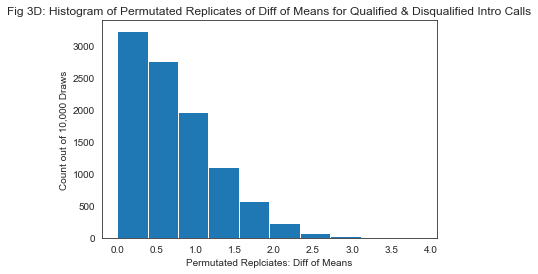


 
 

Proportion of replicates with value as great or greater than empirical diff of means
p-value = 0.1572


In [51]:
# Hypothesis 1: Permutation Test - 
# Simulating the null hypothesis that the two variables have identical distributions
# Measuring the difference between resulting calculated means to understand how much the
# resulting difference would shift compared to the empirical difference between original groups
# If there is no measureable difference, then reshuffling of labels should be arbitrary

# p-value in this case is measuring the proportion of replicates that have as 
# big a value as the empirical diff (or greater)
# Statistically significant p-value is low
# i.e. whether it falls into the tails of the empirically derived sampling distribution 

# Compute difference of mean impact force from experiment: empirical_diff_means

force_a = closedWonIntro[['introCallCreated_leadCreated_delta']]
force_a = force_a.dropna()

force_b = closedLostIntro[['introCallCreated_leadCreated_delta']]
force_b = force_b.dropna()

print("Qualified Intro Calls (Time Duration of Lead to Intro call Created): ", force_a.head(20))
print("\n \n \n")
print("Disqualified Intro Calls (Time Duration of Lead to Intro call Created): ", force_b.head(20))

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

print("\n \n \n")
print("Empirical Diff of Mean:", empirical_diff_means)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates= draw_perm_reps(force_a, force_b, diff_of_means, size=10000)


print("\n")

fig4 = plt.hist(perm_replicates)
fig4 = plt.xlabel('Permutated Replciates: Diff of Means')
fig4 = plt.ylabel('Count out of 10,000 Draws')
fig4 = plt.title('Fig 3D: Histogram of Permutated Replicates of Diff of Means for Qualified & Disqualified Intro Calls')


plt.show()


# Compute p-value: p
p = len(perm_replicates[perm_replicates >= empirical_diff_means]) / len(perm_replicates)

# Print the result
print("\n \n \n")
print("Proportion of replicates with value as great or greater than empirical diff of means")
print('p-value = %.4f' % p)

[Fig 3D] From the histogram of permuted replicates we can visually see that the empirical mean of 1.5 isn’t an extreme value with about 12% of the permuted values having a value as great or greater than the empirical difference of means. The permutation test result doesn’t seem to provide evidence to reject the null hypothesis that Qualified and Disqualified Intro Calls are significantly different with regards to the Time Delta.




Concatenated Qualified & Disqualified Data: [[ 7.]
 [76.]
 [30.]
 ...
 [91.]
 [26.]
 [58.]]


Mean Values of Concatenated Data:  30.03099186011456


Qualified Intro Call Shifted:      introCallCreated_leadCreated_delta
1                             6.410779
5                            75.410779
7                            29.410779
13                            0.410779
14                            5.410779
16                           20.410779
17                            1.410779
18                          189.410779
20                            1.410779
21                            1.410779


Disqualified Intro Call Shifted:      introCallCreated_leadCreated_delta
0                            10.704942
4                            26.704942
10                            7.704942
11                           47.704942
24                            3.704942
30                           41.704942
31                           10.704942
35                           23.704942
36

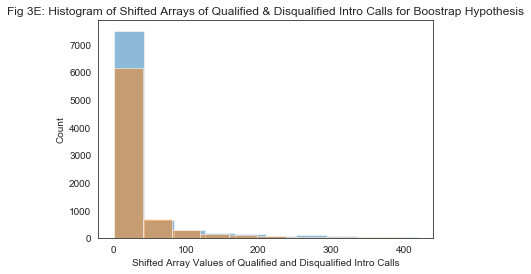


 

Qualified Intro Call Boostrap Replicates:  [30.76222941 29.27905473 30.34768436 ... 31.11843928 29.33196596
 30.77551256]


Disqualified Intro Call Boostrap Replicates:  [30.05575679 29.30790882 29.70494233 ... 29.49265257 29.42339022
 30.64283135]

 
 

Proportion of replicates with value as great or greater than empirical diff of means
p-value = 0.0788


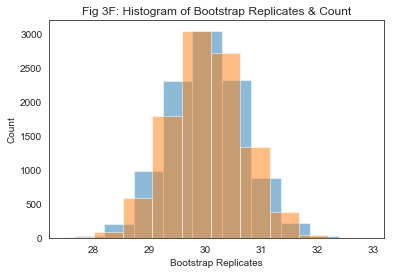

In [52]:
# Hypothesis 2: Two Sample Bootstrap Hypothesis Test for Differences of Means - 

# Simulating the null hypothesis that the two variables are the same 
# but belong to two different distributions. 
# Shift both arrays of data to have the same mean and generate boostrap replicates 
# (draw samples from shifted arrays & compute the difference in means)


# Measuring the difference between resulting calculated means to understand how much the
# resulting difference would shift compared to the empirical difference between original groups


# p-value in this case is measuring the proportion of replicates with a difference in means 
#greater than or equal to observed via the empirrical diff of means




# Compute mean of all forces: mean_force

forces_concat = pd.concat([force_a, force_b])
forces_concat = np.array(forces_concat)

print("\n")
print("Concatenated Qualified & Disqualified Data:", forces_concat)

mean_force = np.mean(forces_concat)
print("\n")
print("Mean Values of Concatenated Data: ", mean_force)


# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

print("\n")
print("Qualified Intro Call Shifted: ", force_a_shifted.head(10))
print("\n")
print("Disqualified Intro Call Shifted: ", force_b_shifted.head(10))

force_a_shifted = np.array(force_a_shifted)
force_b_shifted = np.array(force_b_shifted)

fig5 = plt.hist(force_a_shifted, alpha=0.5)
fig5 = plt.hist(force_b_shifted, alpha=0.5)

fig5 = plt.xlabel('Shifted Array Values of Qualified and Disqualified Intro Calls')
fig5 = plt.ylabel('Count')
fig5 = plt.title('Fig 3E: Histogram of Shifted Arrays of Qualified & Disqualified Intro Calls for Boostrap Hypothesis')


plt.show()

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, size=10000)

print("\n \n")
print("Qualified Intro Call Boostrap Replicates: ", bs_replicates_a)

print("\n")
print("Disqualified Intro Call Boostrap Replicates: ", bs_replicates_b)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)


print("\n \n \n")
print("Proportion of replicates with value as great or greater than empirical diff of means")
print('p-value = %.4f' % p)

fig6 = plt.hist(bs_replicates_a, alpha=0.5)
fig6 = plt.hist(bs_replicates_b, alpha=0.5)
fig6 = plt.xlabel('Bootstrap Replicates')
fig6 = plt.ylabel('Count')
fig6 = plt.title('Fig 3F: Histogram of Bootstrap Replicates & Count')

plt.show()

[Fig 3F] Similarly the Bootstrap test isn’t significant at the 5% level, with ~5.9% of the bootstrap replicates exhibiting a value equal to or greater than the empirical difference of means.

In [53]:
#Using Mann-Whitney Test & Wlech's t-test

print(stats.mannwhitneyu(force_a, force_b))

print(stats.ttest_ind(force_a, force_b, equal_var = False))

MannwhitneyuResult(statistic=32835127.0, pvalue=1.5869054387501494e-05)
Ttest_indResult(statistic=array([1.40082158]), pvalue=array([0.16128627]))


We are seeing conflicted results from the Mann-Whitney test (which seems to reject the null hypothesis that the populations are similar) and Welch’s T-Test (which doesn’t result in a statistically significant p-value).


## Predictive Models


My goal was to understand what features were important to predicting whether an intro call would be qualified.
In order to classify whether intro calls would be classified, I initially built three models: a logistic regression model, a random forests model, and a gradient boosted model. 

Leveraging different feature engineering techniques and hyperparameter tuning, I was able to attain 80 % accuracy in classifying Intro Call qualifications (table of results shown below) with the Gradient Boosted 1-Hot Encoded Model with Hyperparameter tuning. 

The top 5 features across all three models in determining Intro Call Qualification Status included: 
> * inferScore___Lead_AddedInfo
> * totalEMails___Lead_AddedInfo
> * totalCalls___Lead_AddedInfo
> * introCallCreated_leadCreated_delta
> * assignedToRole___IntroCall_OtherInfo_map


The features I assumed would be highly ranked but weren’t included: 
> * country___Lead_LeadCompanyInformation_map
> * trafficChannel___Lead_MarketingInformation_map_map
> * product2___IntroCall_MeetingDetails_WalkMe


#### My approach to data preparation, model building & tuning


* Each model used the same starting dataset (), with all categorical values numerically encoded by creating dictionaries of corresponding values and mapping key-value pairs of through a custom function (clean_map(df, dictToMap, oldColName)).  
 
 
* For each model I first ran each version of the starting data sets, creating a test and train split via sklearn’s trest_train_split function. The test and train sets were scaled with StandardScaler and a new classifier instantiated (LogisticRegression(), RandomForestClassifier(), XGBClassifier()). The models were then trained using the training sets and the classifier objects .fit method, after which they were then used to predict the test data labels and evaluated for performance.


*  In order to further improve the model performance I then used RandomizedSearchCV to search for the best hyperparameters and then used GridSearchCV to further refine the selection of parameters. Especially for the RandomForestClassifier, using RandomizedSearchCV to sample possible combinations of parameters to narrow down the search for the optimal parameters was essential, given all the possible parameters available. 


In [54]:
#Setting up data set

closedIntroCalls_Data_model = closedIntroCalls_Data.copy()
closedIntroCalls_Data_model.head(50)

print(closedIntroCalls_Data_model.columns.values)

['PK_IntroCall_ID___IntroCall_ImportantIDInfo'
 'FK_IntroCalltoOppty___IntroCall_ImportantJoinKey'
 'assignedToRole___IntroCall_OtherInfo' 'name___IntroCall_OtherInfo'
 'isdeleted___IntroCall_ImportantSystemInfo'
 'leadStatus___IntroCall_Outcome'
 'rescheduledFromIntroCall___IntroCall_Outcome'
 'doubleDipper___IntroCall_MeetingDetails'
 'projectDueQ___IntroCall_MeetingDetails'
 'produce1___IntroCall_MeetingDetails'
 'product2___IntroCall_MeetingDetails'
 'appType___IntroCall_MeetingDetails'
 'newOrExistingCustomer___IntroCall_LeadInformation'
 'introCallMktSource___IntroCall_LeadInformation'
 'title___Lead_PersonalInformation'
 'customerType___Lead_LeadCompanyInformation'
 'company___Lead_LeadCompanyInformation'
 'city___Lead_LeadCompanyInformation'
 'state___Lead_LeadCompanyInformation'
 'country___Lead_LeadCompanyInformation'
 'linkedinPage___Lead_MarketingInformation'
 'mktChannelcampaign___Lead_MarketingInformation'
 'landingPage___Lead_MarketingInformation'
 'landingPageUrl___Lead

In [55]:
# Create a new dataframe with selected features (Dataframe 1)  - Hot Encoding
columnsToKeep = ['assignedToRole___IntroCall_OtherInfo','isdeleted___IntroCall_ImportantSystemInfo', 'customerType___Lead_LeadCompanyInformation','country___Lead_LeadCompanyInformation','linkedinPage___Lead_MarketingInformation','landingPage___Lead_MarketingInformation','createddate___Lead_ImportantSystemInfo_clean','createddate___IntroCall_ImportantSystemInfo_clean','Target___IntroCall_Outcome_map','trafficChannel___Lead_MarketingInformation_map','introCallCreated_leadCreated_delta','inferScore___Lead_AddedInfo','totalCalls___Lead_AddedInfo','totalEMails___Lead_AddedInfo','usersAmount___Lead_AddedInfo','employeeCategory___Lead_AddedInfo_map','rescheduled___IntroCall_Outcome_map','customerOrEmployee___IntroCall_MeetingDetails_map','createdDayOFWeek___IntroCall_AddedInfo_map','pitch___Lead_AddedInfo_map','decisionMaker___IntroCall_MeetingDetails_map','product2___IntroCall_MeetingDetails']
closedIntroCalls_Data_model = closedIntroCalls_Data_model[columnsToKeep]




#dictionary values
rescheduled___IntroCall_Outcome_dict={"":0,"Yes - Cancel":1,"No":0,"Yes - No Show":1,"Yes - Reject":1}
customerType___Lead_LeadCompanyInformation_dict={"Enterprise":2,"Startup":1,"":0,"Mid Market":3,"Unknown":0,"Non Profit":4,"Biz Dev Partner":5,"Partner":6}
country___Lead_LeadCompanyInformation_dict={"":0,"United States":1,"Canada":2,"Belgium":3,"Finland":4,"India":5,"United Kingdom":6,"Israel":7,"Egypt":8,"Spain":9,"Sweden":10,"South Africa":11,"Italy":12,"Cayman Islands":13,"Taiwan":14,"Australia":15,"Germany":16,"Czech Republic":17,"France":18,"Brazil":19,"Mexico":20,"New Zealand":21,"Netherlands":22,"Turkey":23,"Argentina":24,"Hong Kong":25,"Fiji":26,"Switzerland":27,"Guyana":28,"Saudi Arabia":29,"Cyprus":30,"United Arab Emirates":31,"Austria":32,"Pakistan":33,"Greece":34,"Norway":35,"Indonesia":36,"Romania":37,"Jordan":38,"Philippines":39,"Russian Federation":40,"Serbia":41,"Sri Lanka":42,"Dominican Republic":43,"Costa Rica":44,"Poland":45,"Ukraine":46,"Singapore":47,"Nigeria":48,"Malaysia":49,"Trinidad and Tobago":50,"Denmark":51,"Ireland":52,"Guatemala":53,"China":54,"Puerto Rico":55,"Hungary":56,"Japan":57,"Swaziland":58,"Qatar":59,"Luxembourg":60,"Nicaragua":61,"Portugal":62,"Kenya":63,"Iceland":64,"Viet Nam":65,"Bulgaria":66,"Colombia":67,"Estonia":68,"Latvia":69,"Bahrain":70,"Peru":71,"Saint Lucia":72,"Chinese Taipei":73,"Lebanon":74,"Malta":75,"Panama":76,"Bermuda":77,"Mauritius":78,"Guernsey":79,"Venezuela":80,"Chile":81,"Azerbaijan":82,"Jersey":83,"Lithuania":84,"Palestin":85,"Kuwait":86,"Morocco":87,"Macedonia":88,"Faroe Islands":89,"Armenia":90,"Kazakhstan":91,"Croatia":92,"Virgin Islands, U.s.":93,"Thailand":94,"Palestine, State Of":95,"CuraÃ§ao":96,"Tunisia":97,"Slovenia":98,"Bahamas":99,"Barbados":100,"Cameroon":101,"Albania":102,"Gibraltar":103,"Belarus":104,"Nepal":105,"Algeria":106,"Liechtenstein":107,"Cote d'Ivoire":108,"Ethiopia":109,"Myanmar":110,"Slovakia":111,"Korea, Republic of":112,"Georgia":113,"Uganda":114,"Tanzania":115}
trafficChannel___Lead_MarketingInformation_map_dict={"":0,"Unknown":1,"Facebook":2,"PPC":3,"Search":4,"Other":5,"User":6,"Website":7,"Email":8,"Partner":9,"Site Banner":10,"Event/Conference":11,"Affiliate":12,"LinkedIn":13,"Brand":14,"Twitter":15,"Bing":16,"Outbound":17,"Blog":18,"SEO":19,"Youtube":20}
assignedToRole___IntroCall_OtherInfo_dict={"Director of Sales- Daniel Blendis":1,"Regional Business Managers Brandon's Team":2,"Senior Sales Director Adam":3,"Director of Sales Development":4,"Regional Business Managers IL Team":5,"Senior Sales Director Chris":6,"C Level Sales Colin Team":7,"C Level Sales Scott's Team":8,"VP Of Sales":9,"Director of Sales Brandon":10,"Director of Sales David Freeman":11,"Sales Dev IL":12,"C Level Sales Chris Team":13,"VP of Business Development":14,"Sales Dev US Team Leader":15,"Regional Business Managers Jordan's Team":16,"Sales Dev IL Team Leader":17,"Regional Business Managers Freeman's Team":18,"Strategic Alliances Manager":19,"VP, Customer Engagement":20,"SMB Sales Team":21,"C Level Team Lead - Chris's Team - Hank":22,"Strategic Partnership Team":23,"Regional Business Manager - Hilton's Team":24,"Sales Dev US":25,"C Level Team Lead - Chris's Team - Danny":26,"Regional Business Managers Brian's Team":27,"Regional Business Managers Jon's Team":28,"HQ":29,"RND":30,"VP Channel Sales":31,"Director of SMB - Matthew":32,"Regional Business Managers Aliisa's Team":33,"Regional Business Managers Garrett's Team":34,"Regional Business Managers Daniel Cohen's Team":35,"Senior Sales Director Mike":36,"Mobile Sales":37,"Director of Sales Daniel Cohen":38,"C Level Sales - Mike's Team":39,"Customer Management Team":40,"Account Management Team - Enterprise International":41,"Sales Dev IL- Outbound Team":42,"VP Channel Sales Raj":43,"Channel Team Director Gareth":44,"C Level Sales ROW":45,"C Level Sales - Danny's Team":46,"VP Global Outbound Demand":47,"AE AU Team":48,"Regional VP Sales Hilton":49,"Director of Sales, Strategic":50,"Mid Market RVP Sales":51,"Regional VP of Strategic Sales Mark":52,"SVP International Sales":53,"Regional Sales Director HV APJ":54}
usersAmount___Lead_AddedInfo_dict = {"18264":1,"100-500":100,"50-100":50,"500+":500,"1252":1000,"2 000":2000,"500":500,"5K - 10K":5000,"1,000+":1000,"180":100,"500-1,000":500,"10000":10000,"600000":500000,"approx 75,000":50000,"1000":1000,"":0}



#mapping 
closedIntroCalls_Data_model = clean_map(closedIntroCalls_Data_model, customerType___Lead_LeadCompanyInformation_dict, 'customerType___Lead_LeadCompanyInformation')
closedIntroCalls_Data_model = clean_map(closedIntroCalls_Data_model, rescheduled___IntroCall_Outcome_dict, 'rescheduled___IntroCall_Outcome_map')
closedIntroCalls_Data_model = clean_map(closedIntroCalls_Data_model, trafficChannel___Lead_MarketingInformation_map_dict, 'trafficChannel___Lead_MarketingInformation_map')
closedIntroCalls_Data_model = clean_map(closedIntroCalls_Data_model, assignedToRole___IntroCall_OtherInfo_dict, 'assignedToRole___IntroCall_OtherInfo')
closedIntroCalls_Data_model = clean_map(closedIntroCalls_Data_model, usersAmount___Lead_AddedInfo_dict, 'usersAmount___Lead_AddedInfo')
closedIntroCalls_Data_model = clean_map(closedIntroCalls_Data_model, country___Lead_LeadCompanyInformation_dict, 'country___Lead_LeadCompanyInformation')


#Manipulating Dataframe 1 - Hot Encoding

#fill na's with 0
closedIntroCalls_Data_model[['trafficChannel___Lead_MarketingInformation_map_map','country___Lead_LeadCompanyInformation_map','customerType___Lead_LeadCompanyInformation_map','rescheduled___IntroCall_Outcome_map_map',
'Target___IntroCall_Outcome_map']] = closedIntroCalls_Data_model[['trafficChannel___Lead_MarketingInformation_map_map','country___Lead_LeadCompanyInformation_map','customerType___Lead_LeadCompanyInformation_map','rescheduled___IntroCall_Outcome_map_map',
'Target___IntroCall_Outcome_map']].fillna(value=0)


closedIntroCalls_Data_model.loc[closedIntroCalls_Data_model['landingPage___Lead_MarketingInformation'].notnull(), 'landingPage___Lead_MarketingInformation'] = 1
closedIntroCalls_Data_model.loc[closedIntroCalls_Data_model['linkedinPage___Lead_MarketingInformation'].notnull(), 'linkedinPage___Lead_MarketingInformation'] = 1
closedIntroCalls_Data_model[['landingPage___Lead_MarketingInformation', 'linkedinPage___Lead_MarketingInformation']] = closedIntroCalls_Data_model[['landingPage___Lead_MarketingInformation', 'linkedinPage___Lead_MarketingInformation']].fillna(value=0)

closedIntroCalls_Data_model['mnth_createddate___Lead_ImportantSystemInfo_clean'] = closedIntroCalls_Data_model.createddate___Lead_ImportantSystemInfo_clean.dt.month
closedIntroCalls_Data_model['mnth_createddate___IntroCall_ImportantSystemInfo_clean'] = closedIntroCalls_Data_model.createddate___IntroCall_ImportantSystemInfo_clean.dt.month


closedIntroCalls_Data_model['year_createddate___Lead_ImportantSystemInfo_clean'] = closedIntroCalls_Data_model.createddate___Lead_ImportantSystemInfo_clean.dt.year
closedIntroCalls_Data_model['year_createddate___IntroCall_ImportantSystemInfo_clean'] = closedIntroCalls_Data_model.createddate___IntroCall_ImportantSystemInfo_clean.dt.year


del closedIntroCalls_Data_model['createddate___Lead_ImportantSystemInfo_clean']
del closedIntroCalls_Data_model['createddate___IntroCall_ImportantSystemInfo_clean']
del closedIntroCalls_Data_model['isdeleted___IntroCall_ImportantSystemInfo']


In [56]:
#Preparing and final processing for the models (HOT encoding)

data = closedIntroCalls_Data_model
cat_vars=['product2___IntroCall_MeetingDetails']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
    

data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
closedIntroCalls_Data_model=data[to_keep]

In [57]:
closedIntroCalls_Data_model = closedIntroCalls_Data_model.replace([np.inf, -np.inf], np.nan)
closedIntroCalls_Data_model = closedIntroCalls_Data_model.fillna(0) 
closedIntroCalls_Data_model = closedIntroCalls_Data_model[~closedIntroCalls_Data_model.isin(['NaN', 'NaT']).any(axis=1)]
closedIntroCalls_Data_model = closedIntroCalls_Data_model.dropna()

### Model 1: Logistic Regression

C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Accuracy Score:  0.7304159913560238


Params:  <bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)>




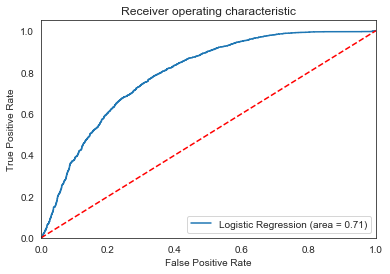

In [58]:
### Using SKleanr logistic Model
# 1 Hot Encoding

from sklearn.preprocessing import StandardScaler

y = closedIntroCalls_Data_model['Target___IntroCall_Outcome_map']
X = closedIntroCalls_Data_model.drop('Target___IntroCall_Outcome_map', axis = 1)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X,y,random_state=5)

sc = StandardScaler()  
Xlr = sc.fit_transform(Xlr)  
Xtestlr = sc.transform(Xtestlr) 

logreg = LogisticRegression()


# Fit the model on the trainng data.
logreg.fit(Xlr, ylr)
ylr_pred = logreg.predict(Xtestlr)

# Print the accuracy from the testing data.
print("Accuracy Score: ", accuracy_score(logreg.predict(Xtestlr), ytestlr))
print("\n")
print("Params: ", logreg.get_params)
print("\n")


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ytestlr, logreg.predict(Xtestlr))
fpr, tpr, thresholds = roc_curve(ytestlr, logreg.predict_proba(Xtestlr)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [59]:
### Perform GridSearchCV

Cs = [ 0.1, 1, 10]
solvers = ['liblinear']
maxIters = [100,150,200]

param_grid = {'C':Cs, 'max_iter':maxIters}

logreg_cv = GridSearchCV(logreg,param_grid, cv=10)
logreg_cv.fit(Xlr, ylr)

print("Best parameter:",logreg_cv.best_params_)
print("Best score:",logreg_cv.best_score_)
print("Test set accuracy:",accuracy_score(ytestlr,logreg_cv.predict(Xtestlr)))

Best parameter: {'C': 1, 'max_iter': 100}
Best score: 0.7354106628242075
Test set accuracy: 0.7304159913560238


### Model 2: Random Forest Classification

In [60]:
#This iteration uses the logistic regression cleaned momdel
#Uses 1 Hot encoding


y_rf = closedIntroCalls_Data_model['Target___IntroCall_Outcome_map']
X_rf = closedIntroCalls_Data_model.drop('Target___IntroCall_Outcome_map', axis = 1)

# Split dataset into training set and test set
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3) # 70% training and 30% test



sc = StandardScaler()  
X_train_rf = sc.fit_transform(X_train_rf)  
X_test_rf = sc.transform(X_test_rf) 

#Create a Gaussian Classifier
rf=RandomForestClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train_rf,y_train_rf)

feature_imp = pd.Series(rf.feature_importances_,index=X_rf.columns).sort_values(ascending=False)
feature_imp_list = pd.DataFrame(feature_imp)
print("Feature Imp: ")
print("-----------------------------------------------------------------")
feature_imp_list



C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


Feature Imp: 
-----------------------------------------------------------------


,0
inferScore___Lead_AddedInfo,0.109470
totalCalls___Lead_AddedInfo,0.091860
totalEMails___Lead_AddedInfo,0.089236
introCallCreated_leadCreated_delta,0.068260
assignedToRole___IntroCall_OtherInfo_map,0.058955
product2___IntroCall_MeetingDetails_WalkMe for Salesforce - Web,0.052003
mnth_createddate___IntroCall_ImportantSystemInfo_clean,0.051931
mnth_createddate___Lead_ImportantSystemInfo_clean,0.051082
trafficChannel___Lead_MarketingInformation_map_map,0.042168
customerOrEmployee___IntroCall_MeetingDetails_map,0.041412


In [61]:
y_pred_rf = rf.predict(X_test_rf)
print("\n")
print("Confusion Matrix (Test Set): ")
print(confusion_matrix(y_test_rf,y_pred_rf))
print("---------------------------------------------------------------------")
print("\n")
print("Classification Report:")  
print(classification_report(y_test_rf,y_pred_rf))
print("----------------------------------------------------------------------")
print("\n")
print("Accuracy Score: ",accuracy_score(y_test_rf, y_pred_rf)) 
print("----------------------------------------------------------------------")
print("\n")

######### CM on train set
print("Confusion Matrix (Train Set): ")
y_pred_rf = rf.predict(X_train_rf)
print(confusion_matrix(y_train_rf,y_pred_rf))
print("\n")
tn, fp, fn, tp = confusion_matrix(y_train_rf,y_pred_rf).ravel()
print("tn: ",tn)
print("fp: ",fp)
print("fn: ", fn)
print("tp: ",tp)



Confusion Matrix (Test Set): 
[[2129  810]
 [ 920 2804]]
---------------------------------------------------------------------


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      2939
           1       0.78      0.75      0.76      3724

   micro avg       0.74      0.74      0.74      6663
   macro avg       0.74      0.74      0.74      6663
weighted avg       0.74      0.74      0.74      6663

----------------------------------------------------------------------


Accuracy Score:  0.740357196458052
----------------------------------------------------------------------


Confusion Matrix (Train Set): 
[[6873   53]
 [  91 8529]]


tn:  6873
fp:  53
fn:  91
tp:  8529


No handles with labels found to put in legend.


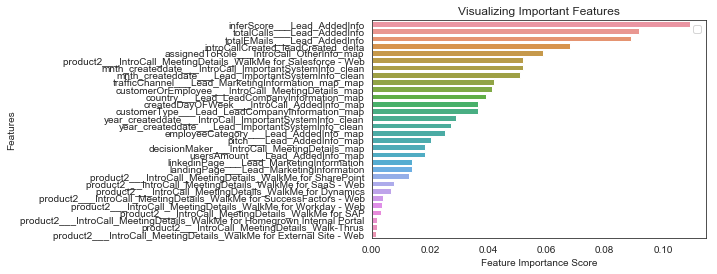

In [62]:

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[:30], y=feature_imp.index[:30])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()
print("\n")

In [63]:
#### Visualizing Tree


# Pull out one tree from the forest
tree = rf.estimators_[5]


# Export the image to a dot file
feature_list = list(X_rf.columns)
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree_rf.png');


# Limit depth of tree to 2 levels
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 8, random_state=42)
rf_small.fit(X_train_rf,y_train_rf)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree_rf.png');

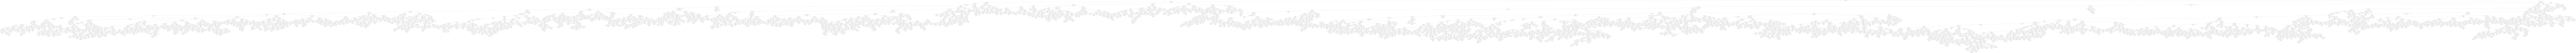

In [64]:
Image("tree_rf.png")

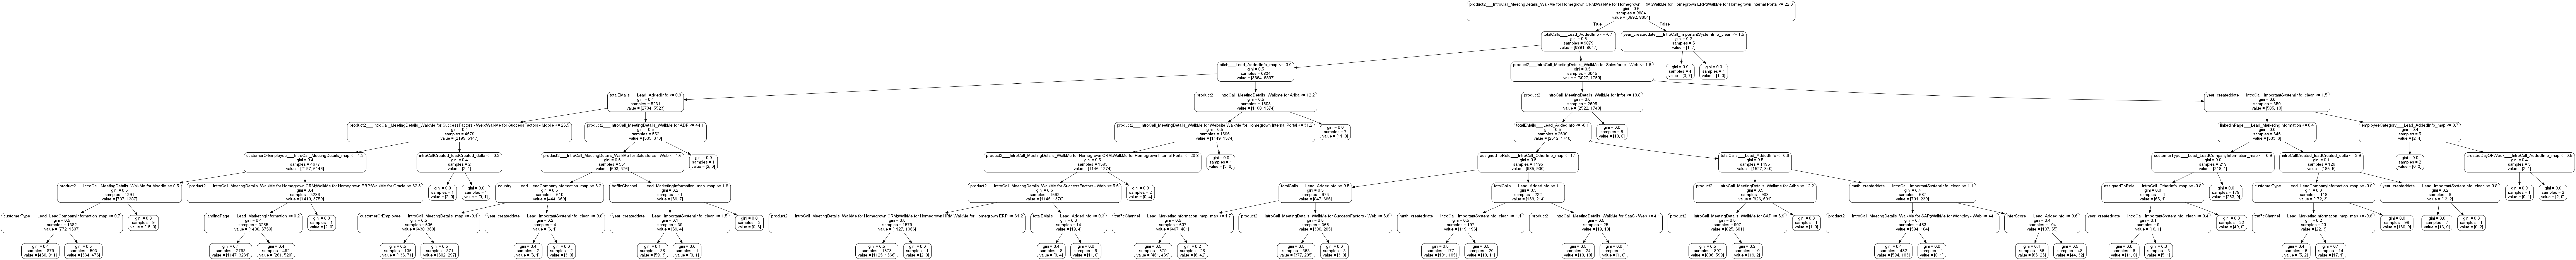

In [65]:
Image("small_tree_rf.png")

In [66]:
print('Parameters currently in use:\n')
rf.get_params()

Parameters currently in use:



{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [67]:
### Sample potential parameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5)
# Fit the random search model
rf_random.fit(X_train_rf, y_train_rf)

rf_random.best_params_


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': True}

In [68]:
# Create the parameter grid based on the results of random search 
param_grid = {'n_estimators': [400],
 'min_samples_split': [7, 10, 13],
 'min_samples_leaf': [1,3,5],
 'max_features': ['sqrt'],
 'max_depth': [20,40,50,60],
 'bootstrap': [False]}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_rf, y_train_rf)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 12.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [400], 'min_samples_split': [7, 10, 13], 'min_samples_leaf': [1, 3, 5], 'max_features': ['sqrt'], 'max_depth': [20, 40, 50, 60], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [69]:
print("Best parameter:",grid_search.best_params_)
print("Best score:",grid_search.best_score_)
print("Test set accuracy:",accuracy_score(y_test_rf,grid_search.predict(X_test_rf)))

print("\n")
print(confusion_matrix(y_test_rf,grid_search.predict(X_test_rf)))
print("\n")
tn, fp, fn, tp = confusion_matrix(y_test_rf,grid_search.predict(X_test_rf)).ravel()
print("tn: ",tn)
print("fp: ",fp)
print("fn: ", fn)
print("tp: ",tp)

Best parameter: {'bootstrap': False, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 400}
Best score: 0.7886916248552682
Test set accuracy: 0.7936365000750413


[[2017  922]
 [ 453 3271]]


tn:  2017
fp:  922
fn:  453
tp:  3271


### Model 3: Gradient Boosted Classification

In [70]:
#This iteration uses the logistic regression cleaned momdel
# Tjis one uses 1 Hot encoding


y_gb = closedIntroCalls_Data_model['Target___IntroCall_Outcome_map']
X_gb = closedIntroCalls_Data_model.drop('Target___IntroCall_Outcome_map', axis = 1)

# Split dataset into training set and test set
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X_gb, y_gb, test_size=0.3) # 70% training and 30% test



sc = StandardScaler()  
X_train_gb = sc.fit_transform(X_train_gb)  
X_test_gb = sc.transform(X_test_gb) 

#Create a Gaussian Classifier
gb = XGBClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
gb.fit(X_train_gb,y_train_gb)

print(gb)

feature_imp_gb = pd.Series(gb.feature_importances_,index=X_gb.columns).sort_values(ascending=False)
feature_imp_gb_list = pd.DataFrame(feature_imp_gb)

print("Feature Imp: ")
feature_imp_gb_list




C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Feature Imp: 


,0
totalEMails___Lead_AddedInfo,0.109177
introCallCreated_leadCreated_delta,0.077532
customerType___Lead_LeadCompanyInformation_map,0.077532
inferScore___Lead_AddedInfo,0.069620
year_createddate___IntroCall_ImportantSystemInfo_clean,0.066456
totalCalls___Lead_AddedInfo,0.063291
product2___IntroCall_MeetingDetails_WalkMe for Salesforce - Web,0.061709
customerOrEmployee___IntroCall_MeetingDetails_map,0.045886
year_createddate___Lead_ImportantSystemInfo_clean,0.042722
product2___IntroCall_MeetingDetails_WalkMe for SharePoint,0.039557


In [71]:
y_pred_gb = gb.predict(X_test_gb)

print("Confusion Matrix (Test Set): ")
print(confusion_matrix(y_test_gb,y_pred_gb))
print("---------------------------------------------------------------------")
print("Classification Report:")  
print(classification_report(y_test_gb,y_pred_gb))
print("----------------------------------------------------------------------")
print("Accuracy Score: ",accuracy_score(y_test_gb, y_pred_gb)) 
print("----------------------------------------------------------------------")

######### CM on train set
print("Confusion Matrix (Train Set): ")
y_pred_gb = gb.predict(X_train_gb)
print(confusion_matrix(y_train_gb,y_pred_gb))


print("\n")
tn, fp, fn, tp = confusion_matrix(y_train_gb,y_pred_gb).ravel()
print("tn: ",tn)
print("fp: ",fp)
print("fn: ", fn)
print("tp: ",tp)

Confusion Matrix (Test Set): 
[[1924 1053]
 [ 432 3254]]
---------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.65      0.72      2977
           1       0.76      0.88      0.81      3686

   micro avg       0.78      0.78      0.78      6663
   macro avg       0.79      0.76      0.77      6663
weighted avg       0.78      0.78      0.77      6663

----------------------------------------------------------------------
Accuracy Score:  0.7771274200810446
----------------------------------------------------------------------
Confusion Matrix (Train Set): 
[[4460 2428]
 [ 920 7738]]


tn:  4460
fp:  2428
fn:  920
tp:  7738


No handles with labels found to put in legend.


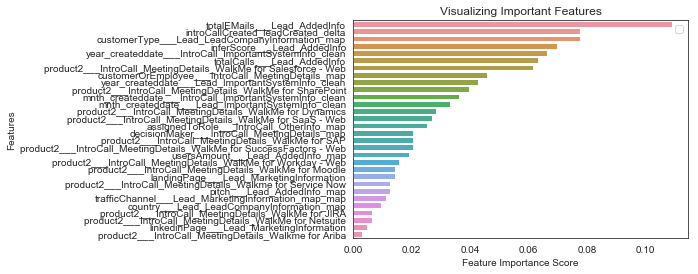

In [72]:


%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp_gb[:30], y=feature_imp_gb.index[:30])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [73]:
print('Parameters currently in use:\n')
gb.get_params()

Parameters currently in use:



{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [74]:
### Create randomized search cv for gradient boosted

minChildWeight = [1, 5, 10]
gama = [0.5, 1, 1.5, 2, 5]
subsampl = [0.6, 0.8, 1.0]
colSampbyTree = [0.6, 0.8, 1.0]
maxDepth = [3, 4, 5]

# Create the random grid
random_grid = {'min_child_weight': minChildWeight,
        'gamma': gama,
        'subsample': subsampl,
        'colsample_bytree': colSampbyTree,
        'max_depth': maxDepth}


# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, cv = 5)
# Fit the random search model
gb_random.fit(X_train_rf, y_train_rf)

gb_random.best_params_


{'subsample': 0.8,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 2,
 'colsample_bytree': 1.0}

In [75]:
# Create the parameter grid based on the results of random search 
param_grid = {'subsample': [1.0],
 'min_child_weight': [8,9,10,11,12,15],
 'max_depth': [4,5,6],
 'gamma': [1, 1.5, 2, 2.5, 3],
 'colsample_bytree': [1.0]}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_gb, y_train_gb)
grid_search.best_params_

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 16.7min finished


{'colsample_bytree': 1.0,
 'gamma': 2,
 'max_depth': 6,
 'min_child_weight': 8,
 'subsample': 1.0}

In [76]:
print("Best parameter:",grid_search.best_params_)
print("Best score:",grid_search.best_score_)
print("Test set accuracy:",accuracy_score(y_test_gb,grid_search.predict(X_test_gb)))

print("\n")
print(confusion_matrix(y_test_gb,grid_search.predict(X_test_gb)))
print("\n")
tn, fp, fn, tp = confusion_matrix(y_test_gb,grid_search.predict(X_test_gb)).ravel()
print("tn: ",tn)
print("fp: ",fp)
print("fn: ", fn)
print("tp: ",tp)

Best parameter: {'colsample_bytree': 1.0, 'gamma': 2, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 1.0}
Best score: 0.7899781294223595
Test set accuracy: 0.7982890589824403


[[2068  909]
 [ 435 3251]]


tn:  2068
fp:  909
fn:  435
tp:  3251
